# 5章 離散最適化で広告出稿番組を選択する

## ビジネス課題：番組選択の最適化

## ステップ1：ビジネス課題を数理最適化問題として定式化する

## ステップ2：数理モデル構築し、未知のパラメータをデータから推定する

In [1]:
import json  # ファイル読み込み

import matplotlib.pyplot as plt  # 可視化
import numpy as np  # データ処理
import polars as pl  # データ処理
import seaborn as sns  # 可視化
from matplotlib.axes import Axes  # 型ヒント
from matplotlib.figure import Figure  # 型ヒント
from matplotlib.ticker import PercentFormatter  # 可視化

In [2]:
# 乱数を固定
np.random.seed(42)

# データの表示設定
pl.Config.set_float_precision(precision=3)
pl.Config.set_tbl_cols(14)
np.set_printoptions(precision=3)

# 可視化の設定
with open("../setting/visualization.json") as f:
    setting = json.load(f)
sns.set_theme(**setting)
sns.set_palette("gray", 4)

In [3]:
# データの読み込み
df_company_reach = pl.read_parquet("../data/ch05/company_reach.parquet")

# データの確認
df_company_reach

is_train,k,r,sum_d,j_list,d_001,d_002,…,d_107,d_108,d_109,d_110,d_111,d_112,d_113
i32,u32,f64,u32,list[u32],u8,u8,…,u8,u8,u8,u8,u8,u8,u8
1,1,0.072,1,[1],1,0,…,0,0,0,0,0,0,0
1,2,0.164,2,"[1, 61]",1,0,…,0,0,0,0,0,0,0
1,3,0.211,5,"[1, 30, … 107]",1,0,…,1,0,0,0,0,0,0
1,4,0.316,11,"[1, 15, … 110]",1,0,…,0,0,0,1,0,0,0
1,5,0.266,6,"[1, 23, … 107]",1,0,…,1,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,416,0.018,1,[110],0,0,…,0,0,0,1,0,0,0
0,417,0.093,2,"[110, 113]",0,0,…,0,0,0,1,0,0,1
0,418,0.035,1,[111],0,0,…,0,0,0,0,1,0,0


In [4]:
# 学習用データと評価用データに分割
# 評価用データは、複数番組に出稿がある企業に限定
df_company_reach_train = df_company_reach.filter(pl.col.is_train == 1)
df_company_reach_valid = df_company_reach.filter(pl.col.is_train == 0, pl.col.sum_d > 1)

company_count_train = df_company_reach_train.shape[0]
company_count_valid = df_company_reach_valid.shape[0]
print(f"学習用データに含まれる企業数：{company_count_train}")
print(f"評価用データに含まれる企業数：{company_count_valid}")

学習用データに含まれる企業数：213
評価用データに含まれる企業数：92


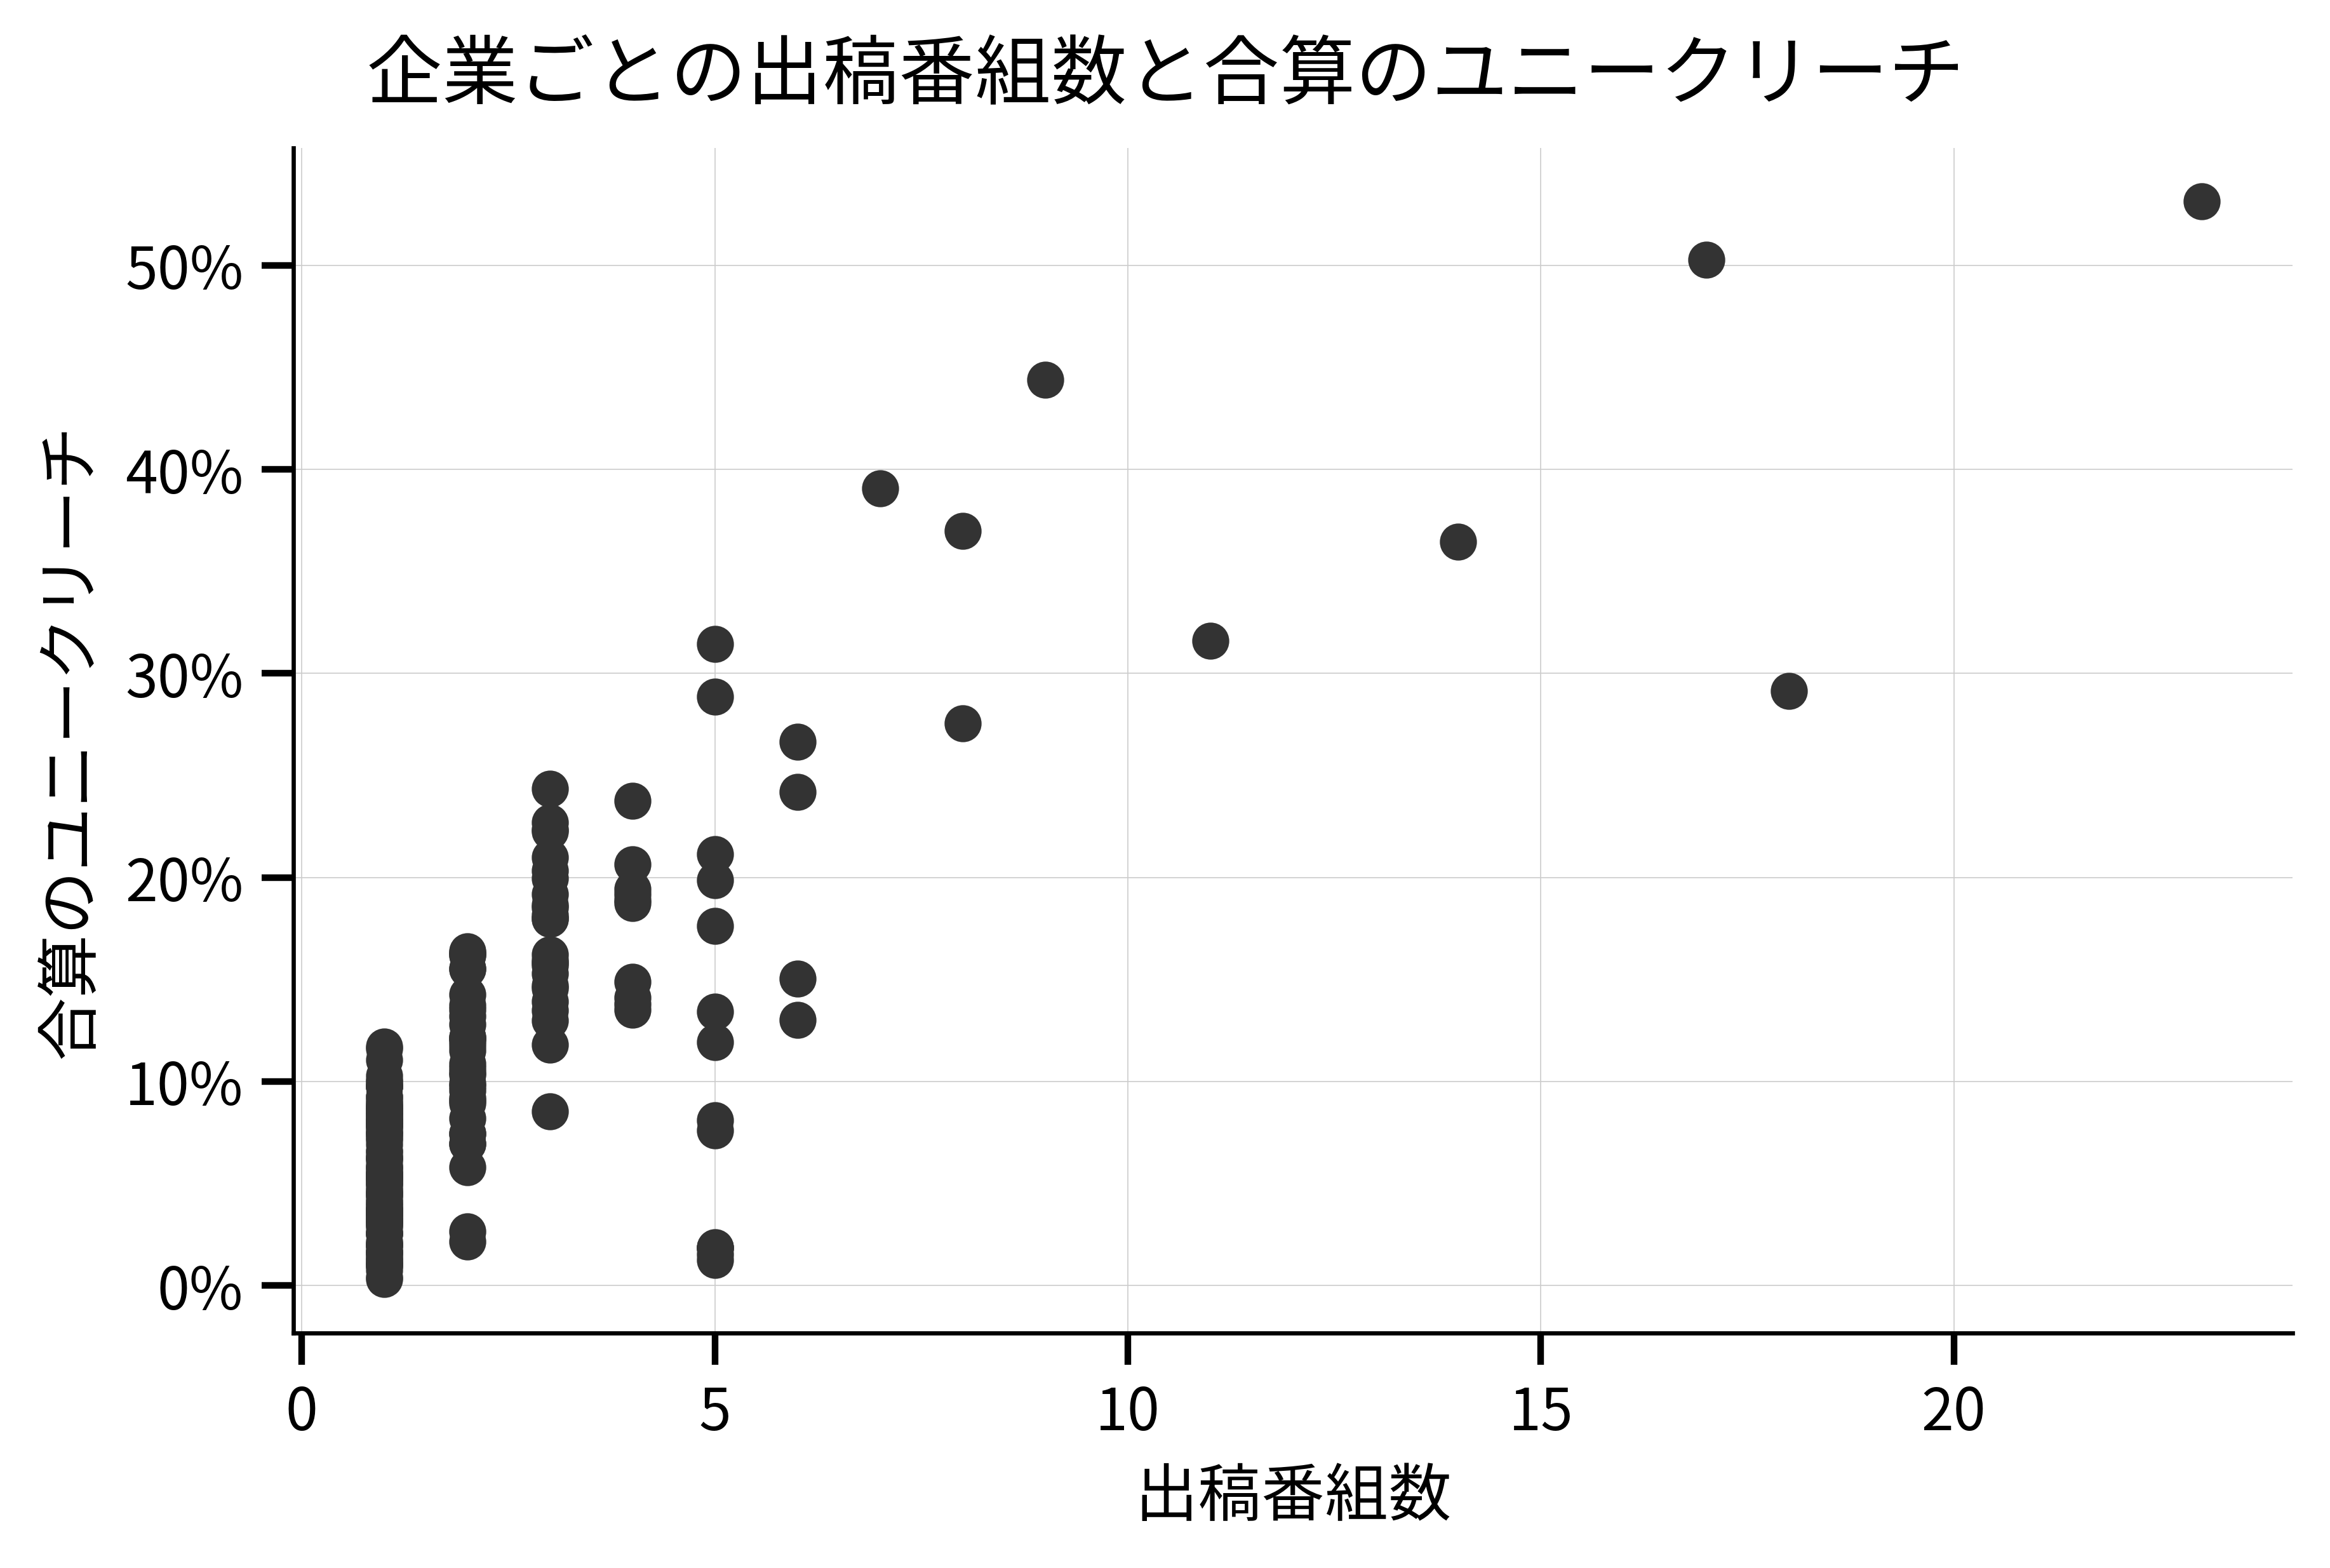

In [5]:
def plot_scatter(
    x: np.ndarray | pl.Series,
    y: np.ndarray | pl.Series,
    xlabel: str,
    ylabel: str,
    title: str,
) -> tuple[Figure, Axes]:
    """散布図を描く"""

    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    fig.suptitle(title)

    return fig, ax


# 散布図を可視化
fig, ax = plot_scatter(
    x=df_company_reach_train["sum_d"],
    y=df_company_reach_train["r"],
    xlabel="出稿番組数",
    ylabel="合算のユニークリーチ",
    title="企業ごとの出稿番組数と合算のユニークリーチ",
)

In [6]:
# 学習用データ
# ダミー変数の部分を説明変数として抽出
X_train = df_company_reach_train.select(pl.selectors.starts_with("d_")).to_numpy()
# 目的変数は合算のユニークリーチ
y_train = df_company_reach_train["r"].to_numpy()

# 評価用データ
X_valid = df_company_reach_valid.select(pl.selectors.starts_with("d_")).to_numpy()
y_valid = df_company_reach_valid["r"].to_numpy()

In [7]:
from sklearn.linear_model import LinearRegression

# モデルの学習。切片を含めないため、fit_intercept=False
lr = LinearRegression(fit_intercept=False).fit(X_train, y_train)

# 予測
y_pred_lr = lr.predict(X_valid)

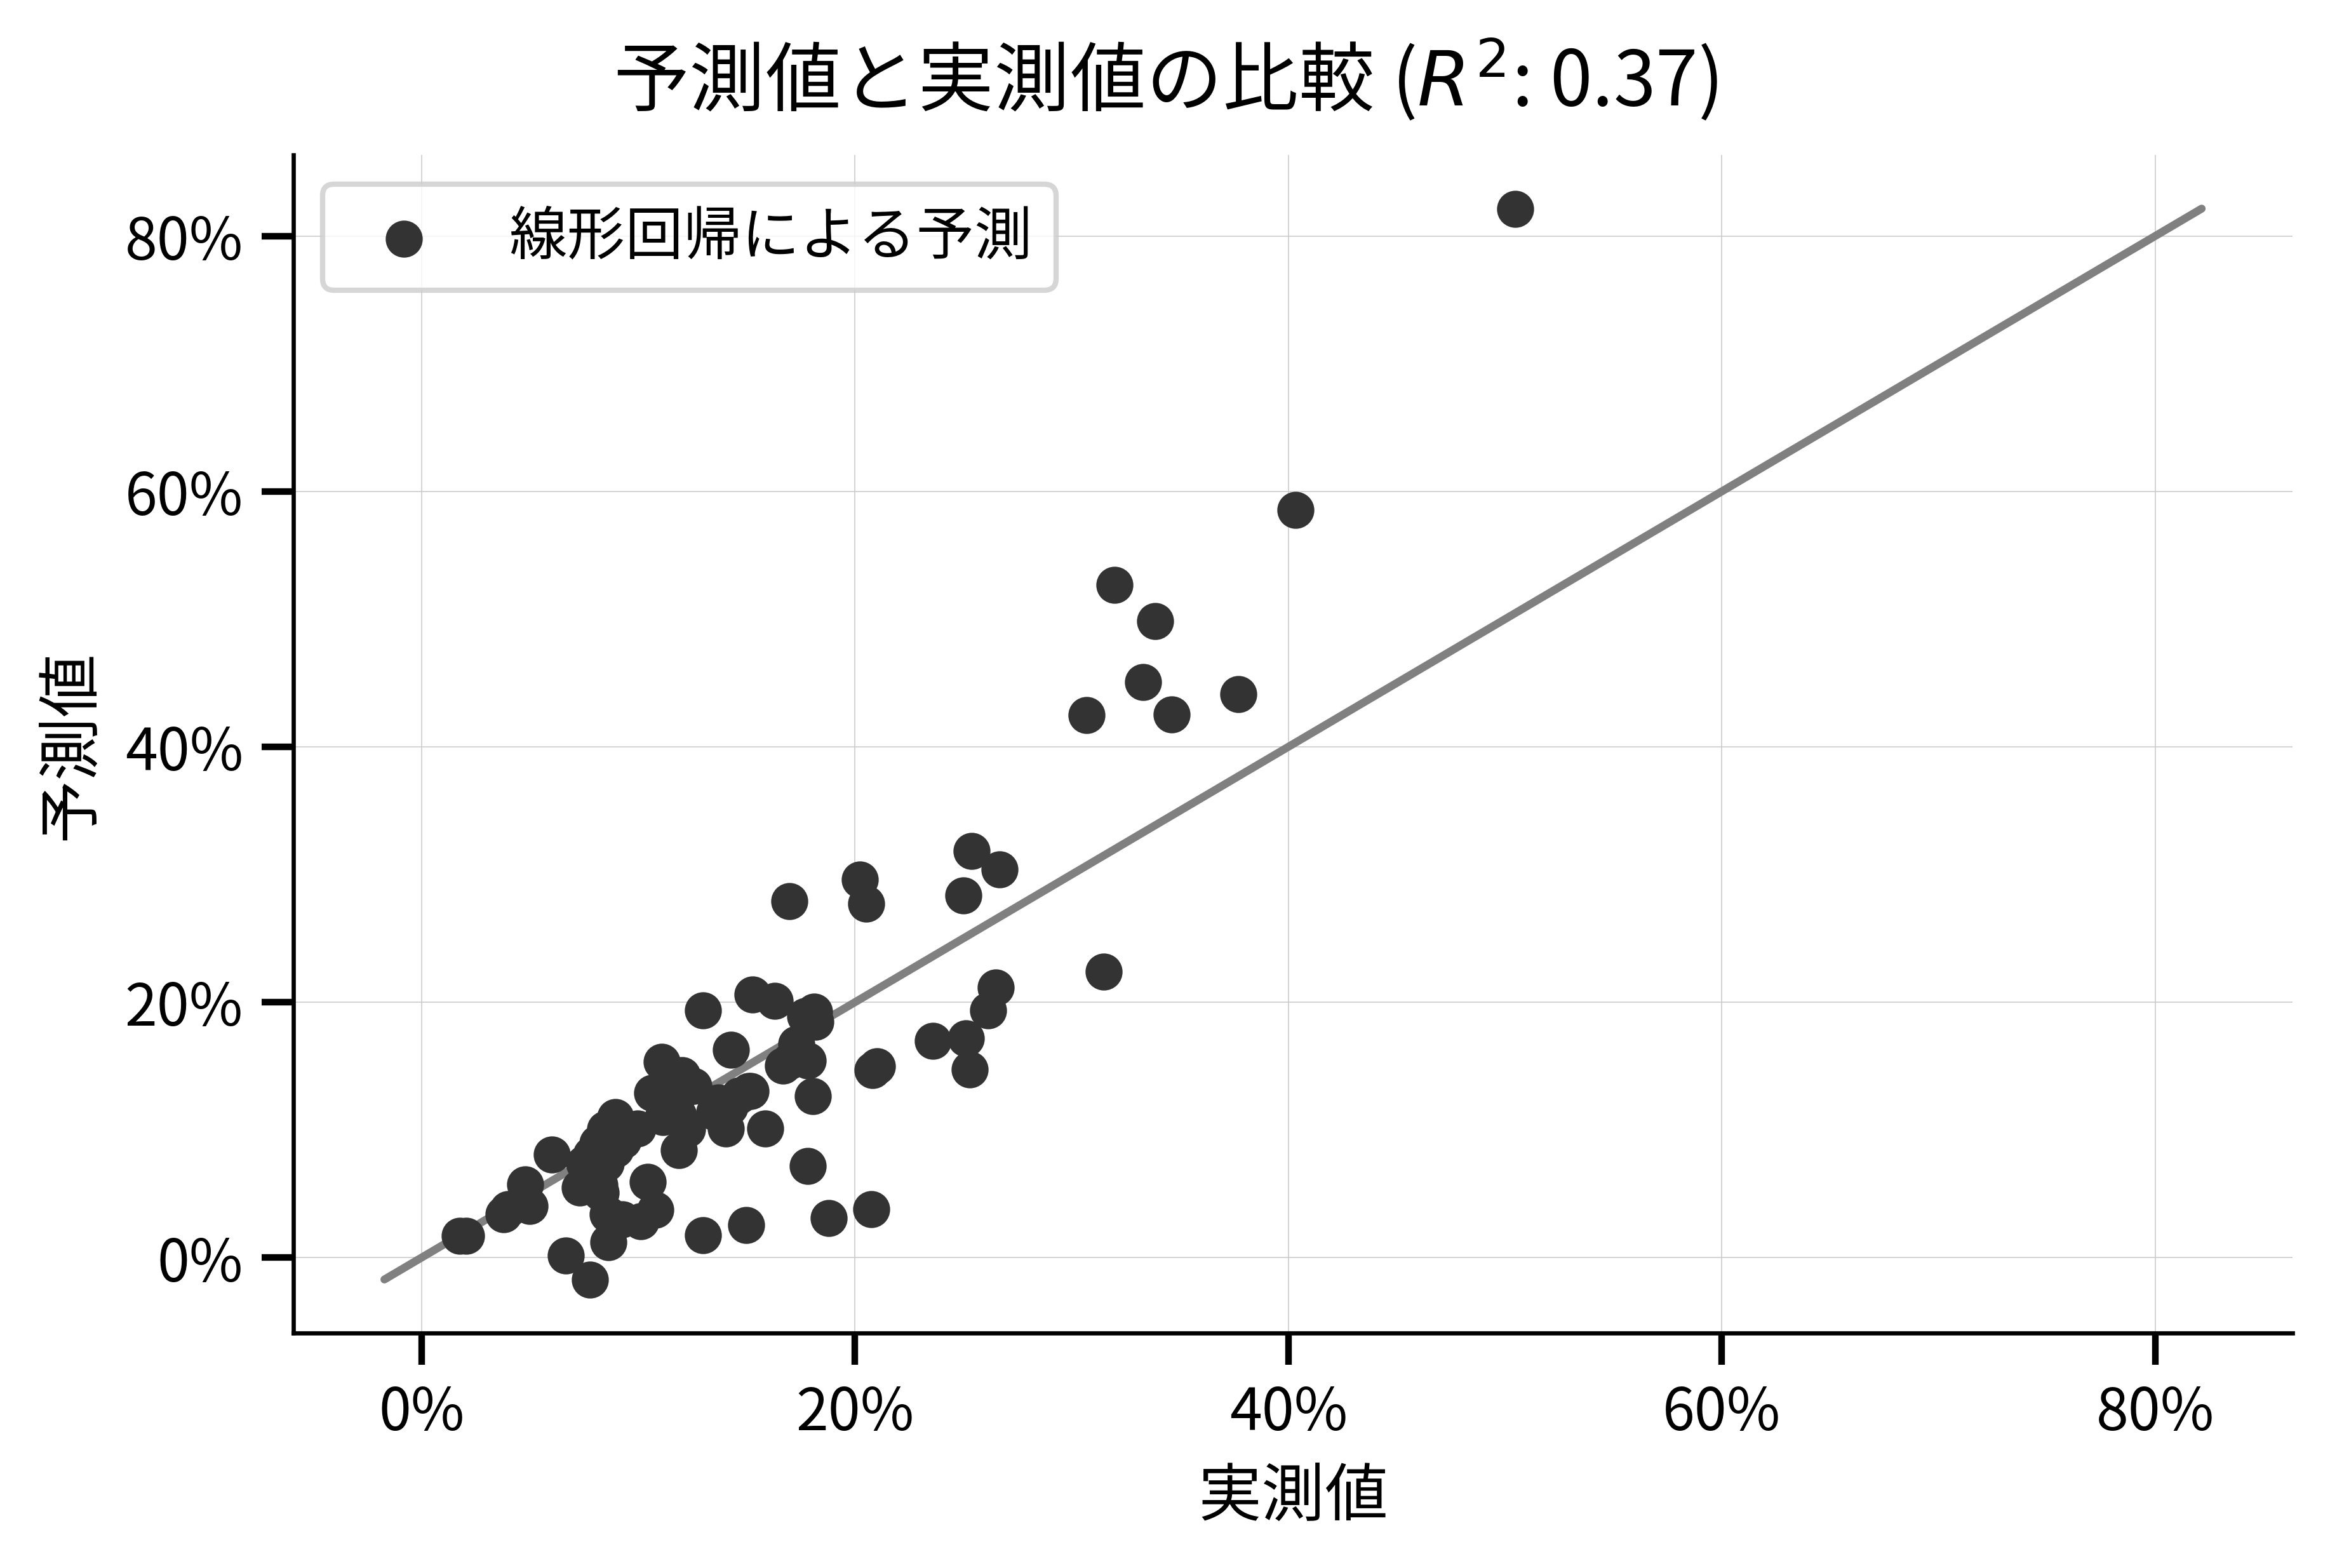

In [8]:
from sklearn.metrics import r2_score  # 決定係数


def plot_compare_actual_prediction(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    prediction_label: str,
    title: str,
) -> tuple[Figure, Axes]:
    """予測値と実測値を比較"""

    # 決定係数
    r2 = r2_score(y_true=y_true, y_pred=y_pred)

    y = np.concatenate([y_true, y_pred])
    x = np.linspace(y.min(), y.max(), 100)  # 対角線

    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, label=prediction_label, zorder=2)
    ax.plot(x, x, c=".5", zorder=1)
    ax.legend()
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set(xlabel="実測値", ylabel="予測値")
    fig.suptitle(f"{title} ($R^2$: {r2:.2f})")

    return fig, ax


# 線形回帰モデルの予測値と実測値を可視化
fig, ax = plot_compare_actual_prediction(
    y_true=y_valid,
    y_pred=y_pred_lr,
    prediction_label="線形回帰による予測",
    title="予測値と実測値の比較",
)

（上記の出力結果は書籍に記載されているものと異なっています。ライブラリのバージョンの微妙な違いによると思われます。）

In [9]:
print(f"説明変数の列数：{X_train.shape[1]}")
print(f"行列のランク：{np.linalg.matrix_rank(X_train)}")

説明変数の列数：113
行列のランク：105


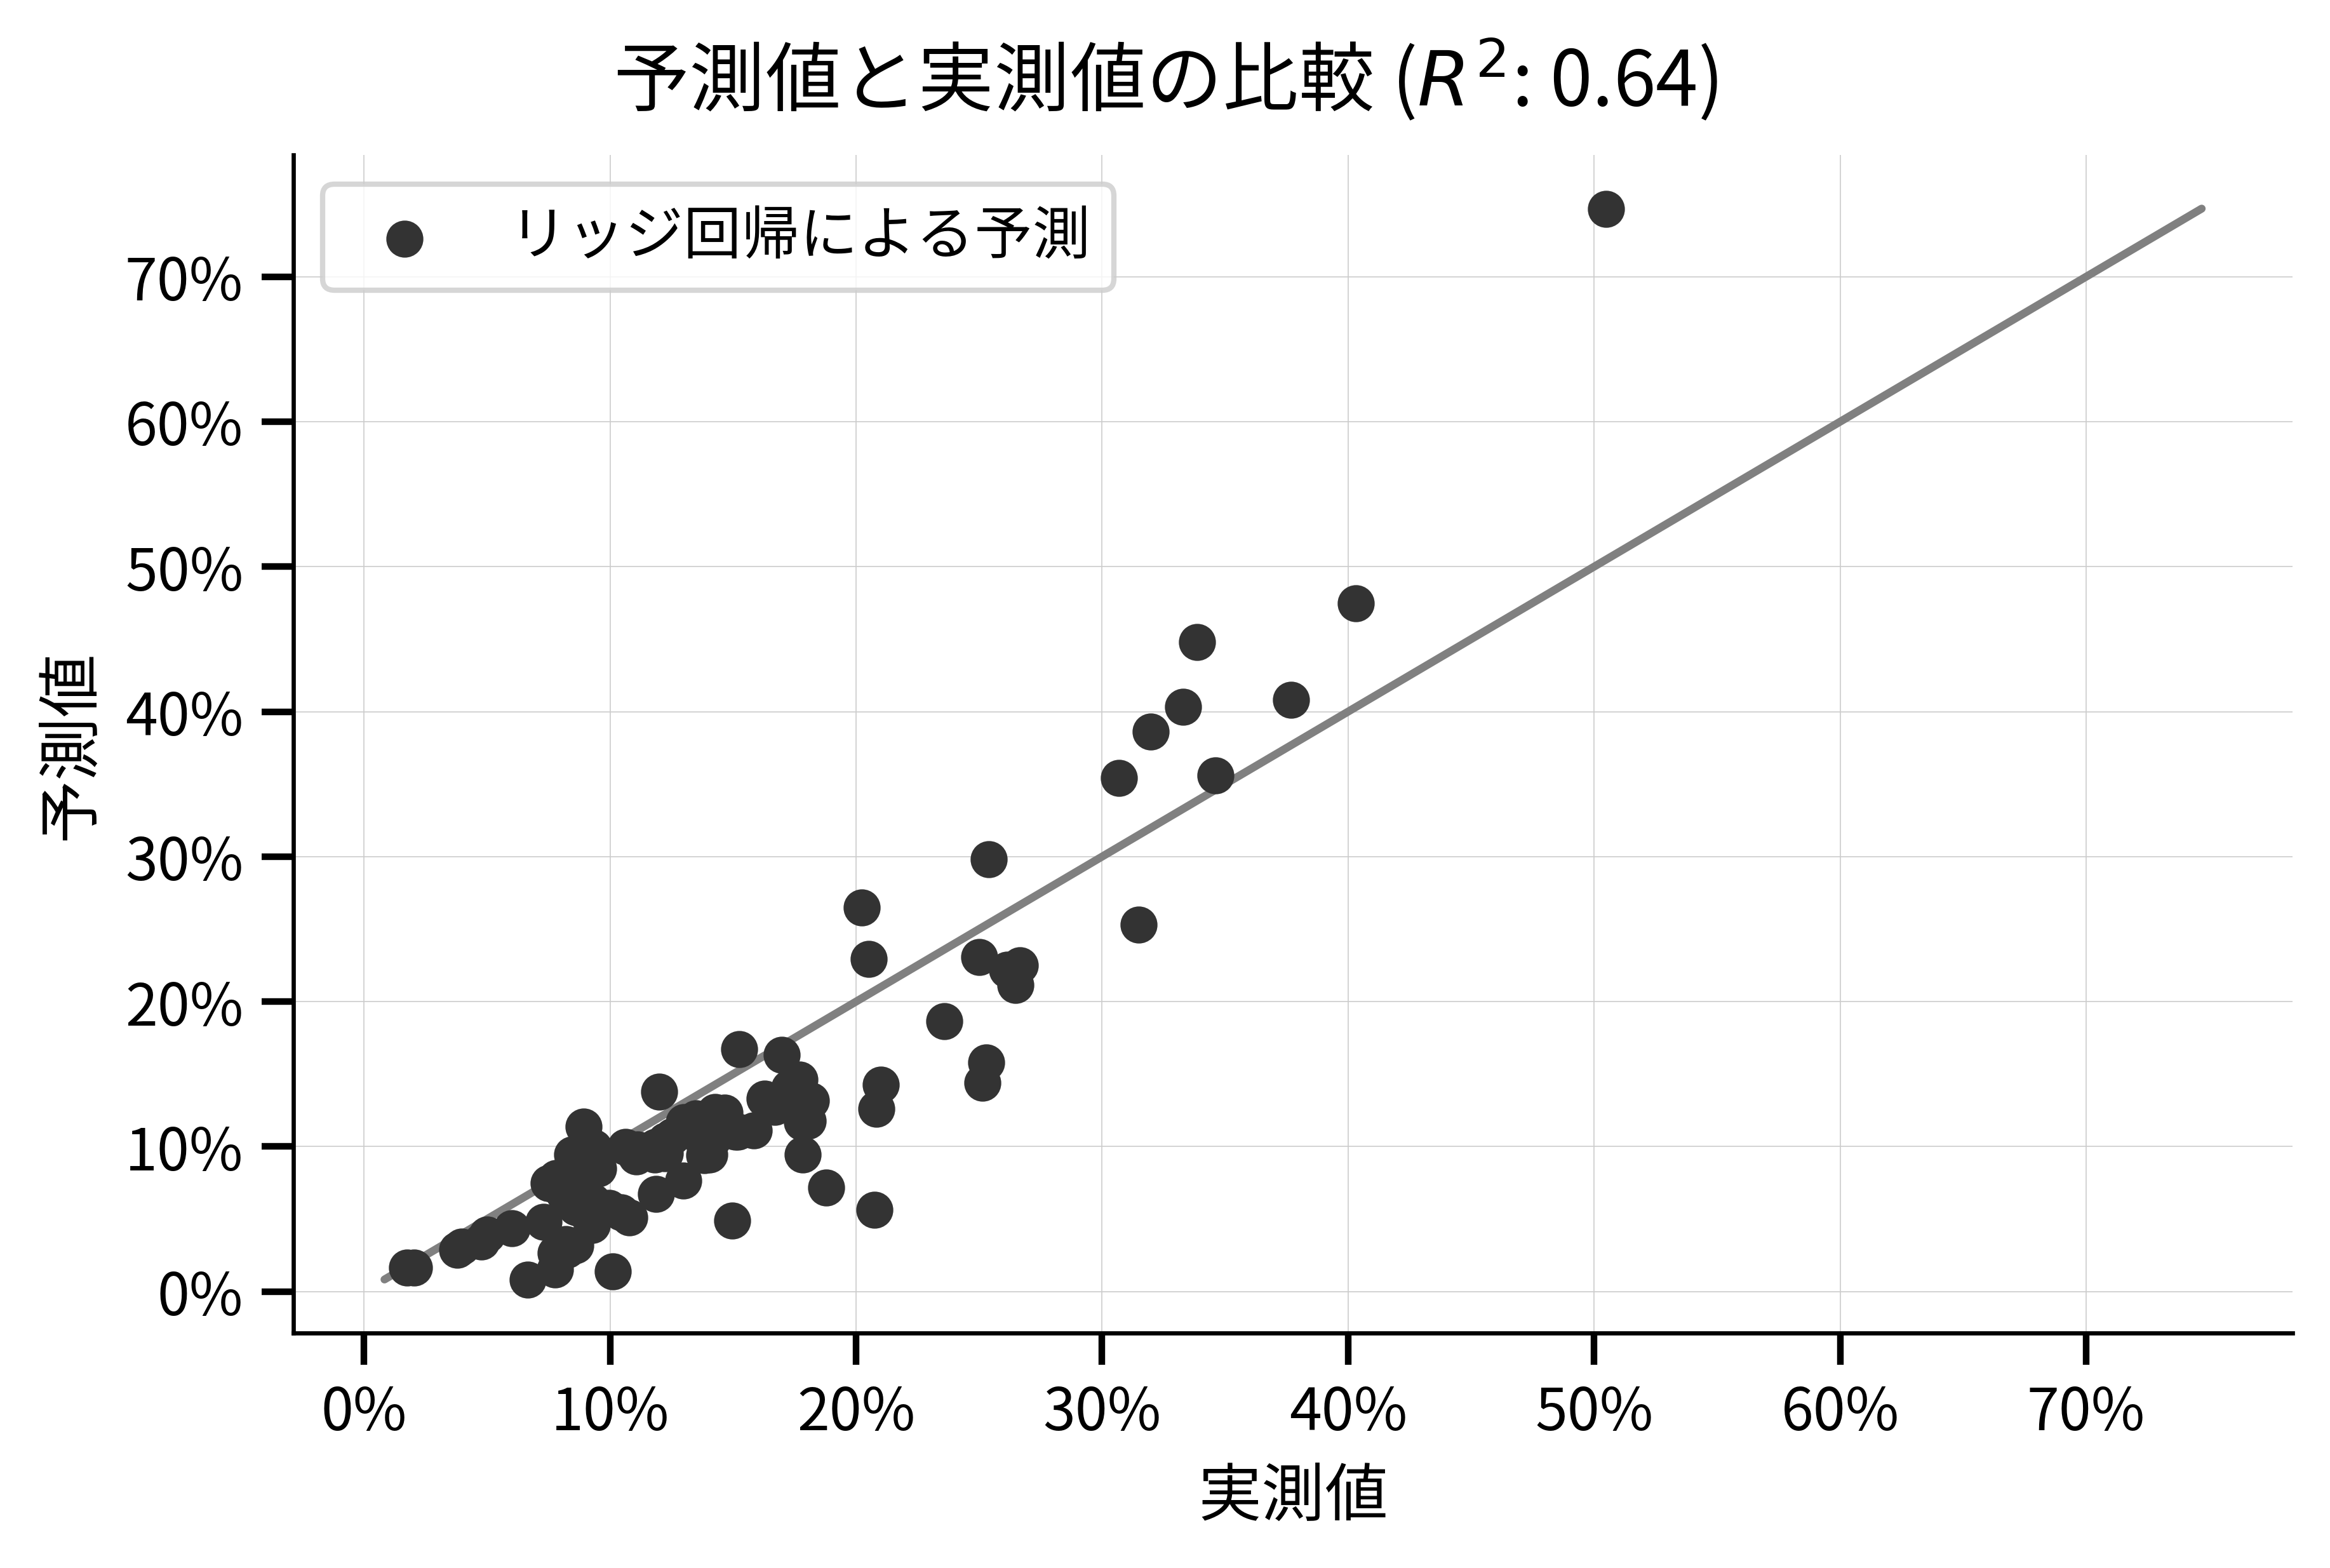

In [10]:
from sklearn.linear_model import Ridge

# モデルの学習。切片を含めないため、fit_intercept=False
# alphaはデフォルトが1だが、明示的に指定
ridge = Ridge(fit_intercept=False, alpha=1, random_state=42).fit(X_train, y_train)

# 予測
y_pred_ridge = ridge.predict(X_valid)

# リッジ回帰の予測値と実測値を可視化
fig, ax = plot_compare_actual_prediction(
    y_true=y_valid,
    y_pred=y_pred_ridge,
    prediction_label="リッジ回帰による予測",
    title="予測値と実測値の比較",
)

In [11]:
from sklearn.ensemble import RandomForestRegressor

# モデルの学習と予測
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)

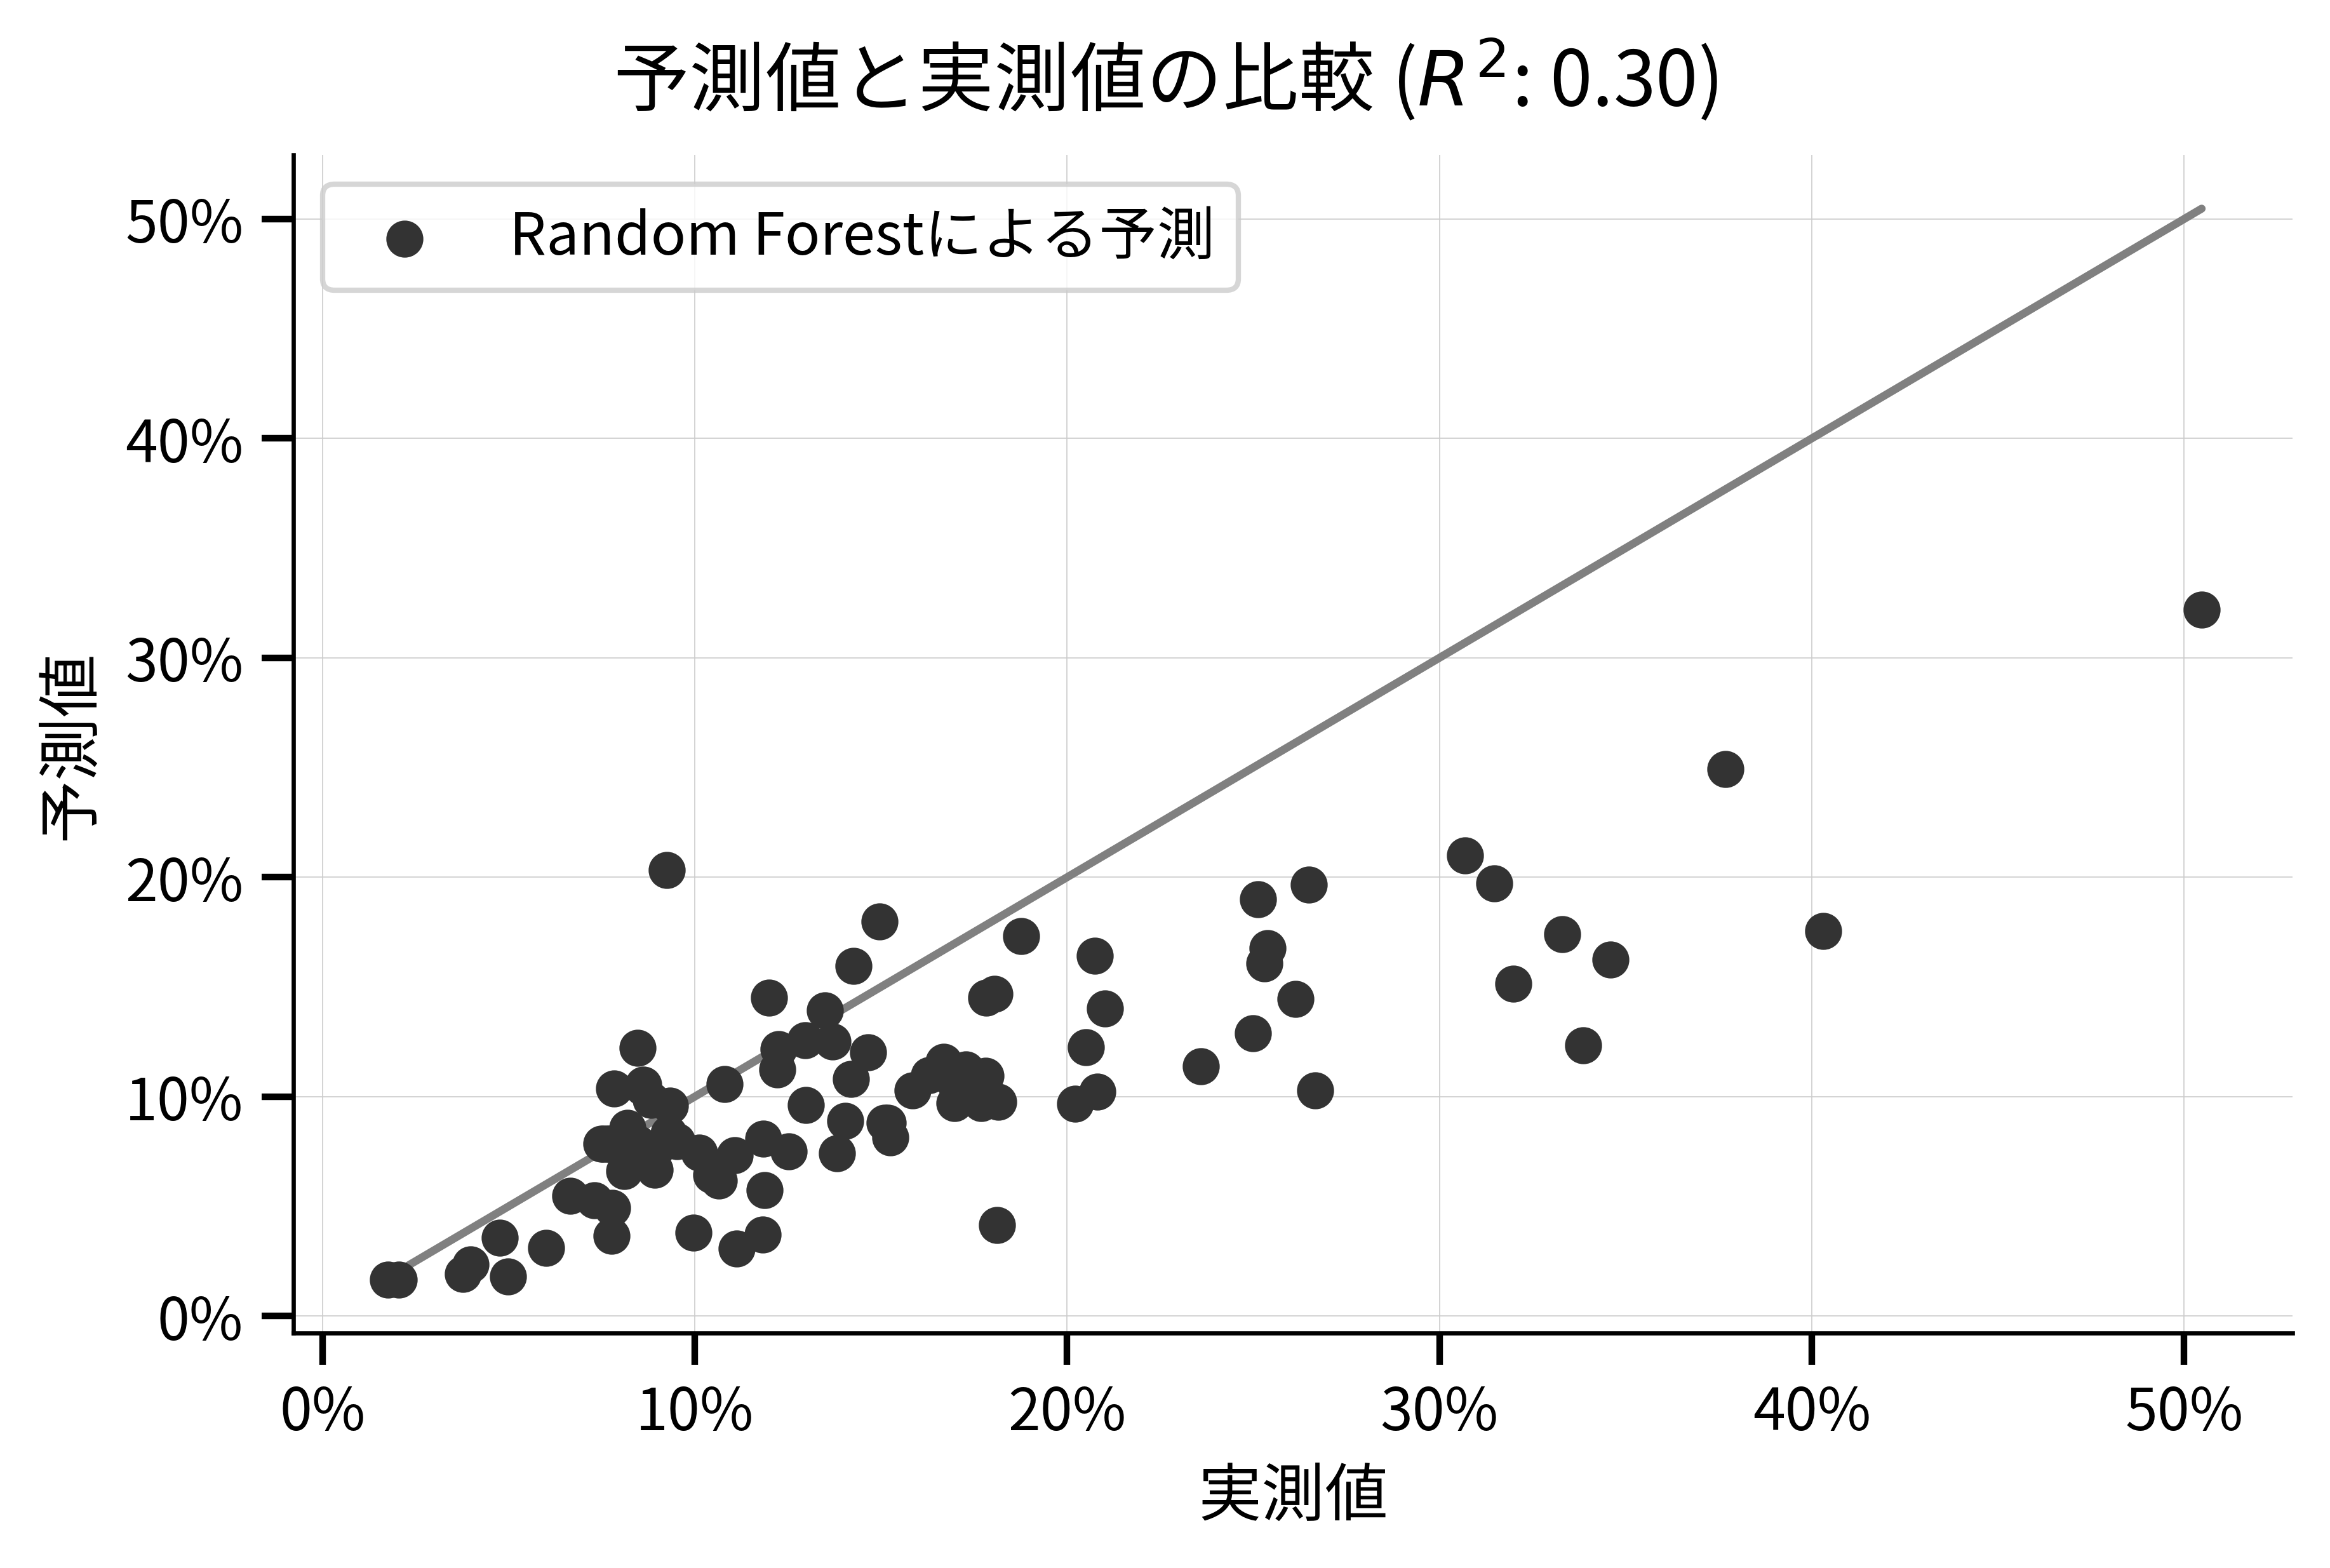

In [12]:
# 可視化
fig, ax = plot_compare_actual_prediction(
    y_true=y_valid,
    y_pred=y_pred_rf,
    prediction_label="Random Forestによる予測",
    title="予測値と実測値の比較",
)

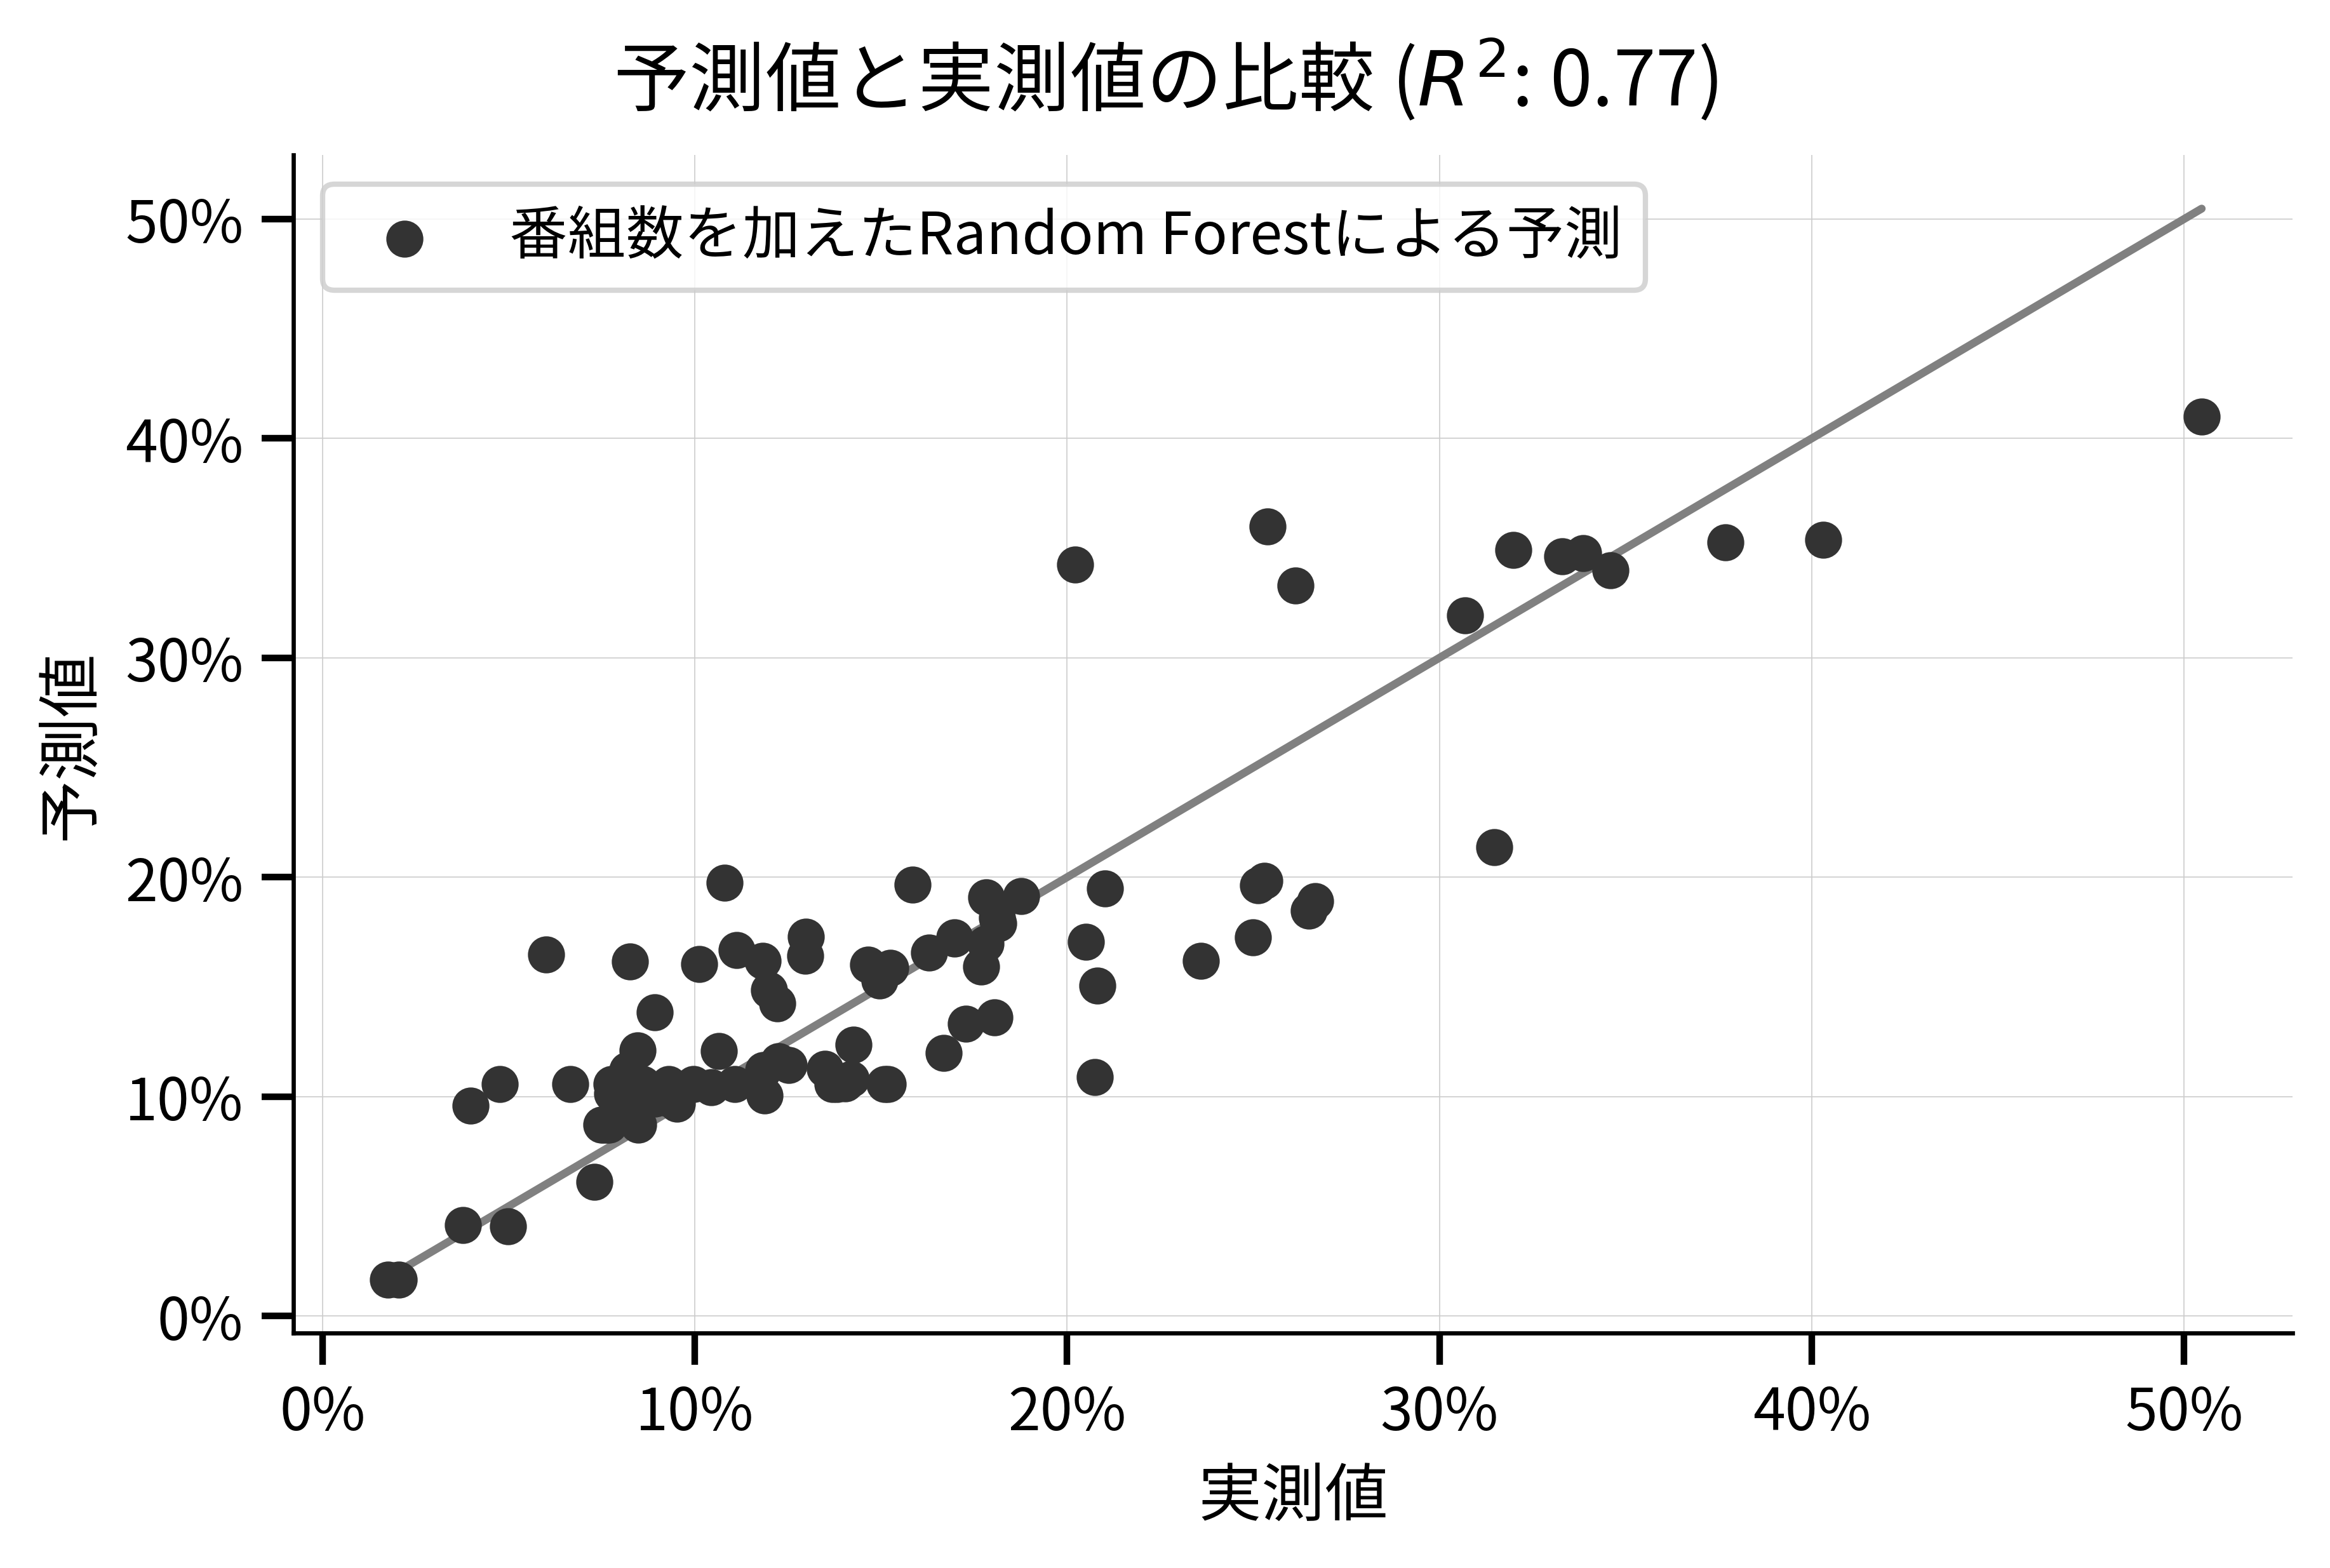

In [13]:
# 番組数を説明変数として追加
sum_d_train = df_company_reach_train["sum_d"].to_numpy()
sum_d_valid = df_company_reach_valid["sum_d"].to_numpy()
X_train2 = np.column_stack([X_train, sum_d_train])
X_valid2 = np.column_stack([X_valid, sum_d_valid])

# モデルの学習と予測
rf2 = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train2, y_train)
y_pred_rf2 = rf2.predict(X_valid2)

# Random Forestによる予測値と実測値を可視化
fig, ax = plot_compare_actual_prediction(
    y_true=y_valid,
    y_pred=y_pred_rf2,
    prediction_label="番組数を加えたRandom Forestによる予測",
    title="予測値と実測値の比較",
)

In [14]:
# 個人ごとのCM接触データを読み込む
df_individual_reach = pl.read_parquet("../data/ch05/individual_reach.parquet")

# データ確認
df_individual_reach

is_train,j,k,i,r
i32,u32,u32,i64,i64
1,1,1,1,0
1,1,1,2,0
1,1,1,3,0
1,1,1,4,0
1,1,1,5,0
…,…,…,…,…
0,113,420,4545,0
0,113,420,4546,1
0,113,420,4547,0


In [15]:
# 学習用データを抽出
df_individual_reach_train = df_individual_reach.filter(pl.col.is_train == 1)

# 個人ごとの各番組のCM接触確率を計算して横持ちで保存
df_reach_prob_train = (
    # 個人ごとの各番組のCM接触確率を計算
    df_individual_reach_train.group_by("i", "j", maintain_order=True)
    .agg(pi=pl.col.r.sum() / pl.col.k.n_unique())
    # 横持ちに変換
    .pivot(on="j", index="i", values="pi")
)

# numpyのndarrayに変換
PI_train = (
    df_reach_prob_train
    # 個人のインデックスが列として入っているので削除
    .drop("i")
    # n行m列の行列に変換
    .to_numpy()
)

# CM接触確率の確認。データフレーム形式のほうがわかりやすいので、こちらを出力
df_reach_prob_train

i,1,2,3,4,5,6,…,107,108,109,110,111,112,113
i64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64
1,0.000,0.667,0.000,0.667,0.000,0.000,…,0.571,0.500,0.000,0.000,0.000,0.000,0.600
2,0.000,1.000,0.000,0.667,0.000,0.000,…,1.000,0.583,0.000,0.750,0.500,0.000,0.200
3,0.000,0.000,0.000,0.000,0.000,0.000,…,1.000,0.833,0.000,0.750,0.250,0.167,0.400
4,0.000,0.333,0.000,0.667,0.000,0.000,…,0.714,0.750,0.000,0.000,0.000,0.333,0.000
5,0.000,0.000,0.000,0.000,0.000,0.000,…,0.714,0.417,0.000,0.000,0.000,1.000,0.200
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
4545,0.000,0.000,0.000,0.000,0.000,0.000,…,0.000,0.667,0.000,0.000,0.000,0.000,0.000
4546,0.333,0.000,0.000,0.333,0.250,0.200,…,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4547,0.000,0.000,0.000,0.000,0.500,0.000,…,0.000,0.000,0.000,0.000,0.250,0.333,0.000


In [16]:
class ProgramUniqueReachEstimator:
    """選択した番組群に対するユニークリーチを予測するモデル"""

    def __init__(self, PI: np.ndarray) -> None:
        """個人ごとの各番組のCMへの接触確率を保持

        Args:
            PI (np.ndarray): 個人ごとの各番組のCMへの接触確率
        """

        # 個人ごとの各番組への接触確率を計算して保存
        self.PI_ = PI
        self.m_ = PI.shape[1]

    def predict(self, D: np.ndarray) -> np.ndarray:
        """選択した番組群に対するユニークリーチを予測

        Args:
            D (np.ndarray): ダミー変数形式の選択した番組群。

        Returns:
            np.ndarray: 合算のユニークリーチの予測値
        """

        # (1 - PI)のD乗を計算したいので、shapeをあわせる
        # (n, m)を(n, m, 1)に
        PI_ = self.PI_[:, :, np.newaxis]
        # (l, m)を(1, m, l)に
        D_ = D.T[np.newaxis, :, :]

        # これで、(1 - PI_) ** D_のshapeが(n, m, l)になる
        r_pred = 1 - ((1 - PI_) ** D_).prod(1).mean(0)

        return r_pred


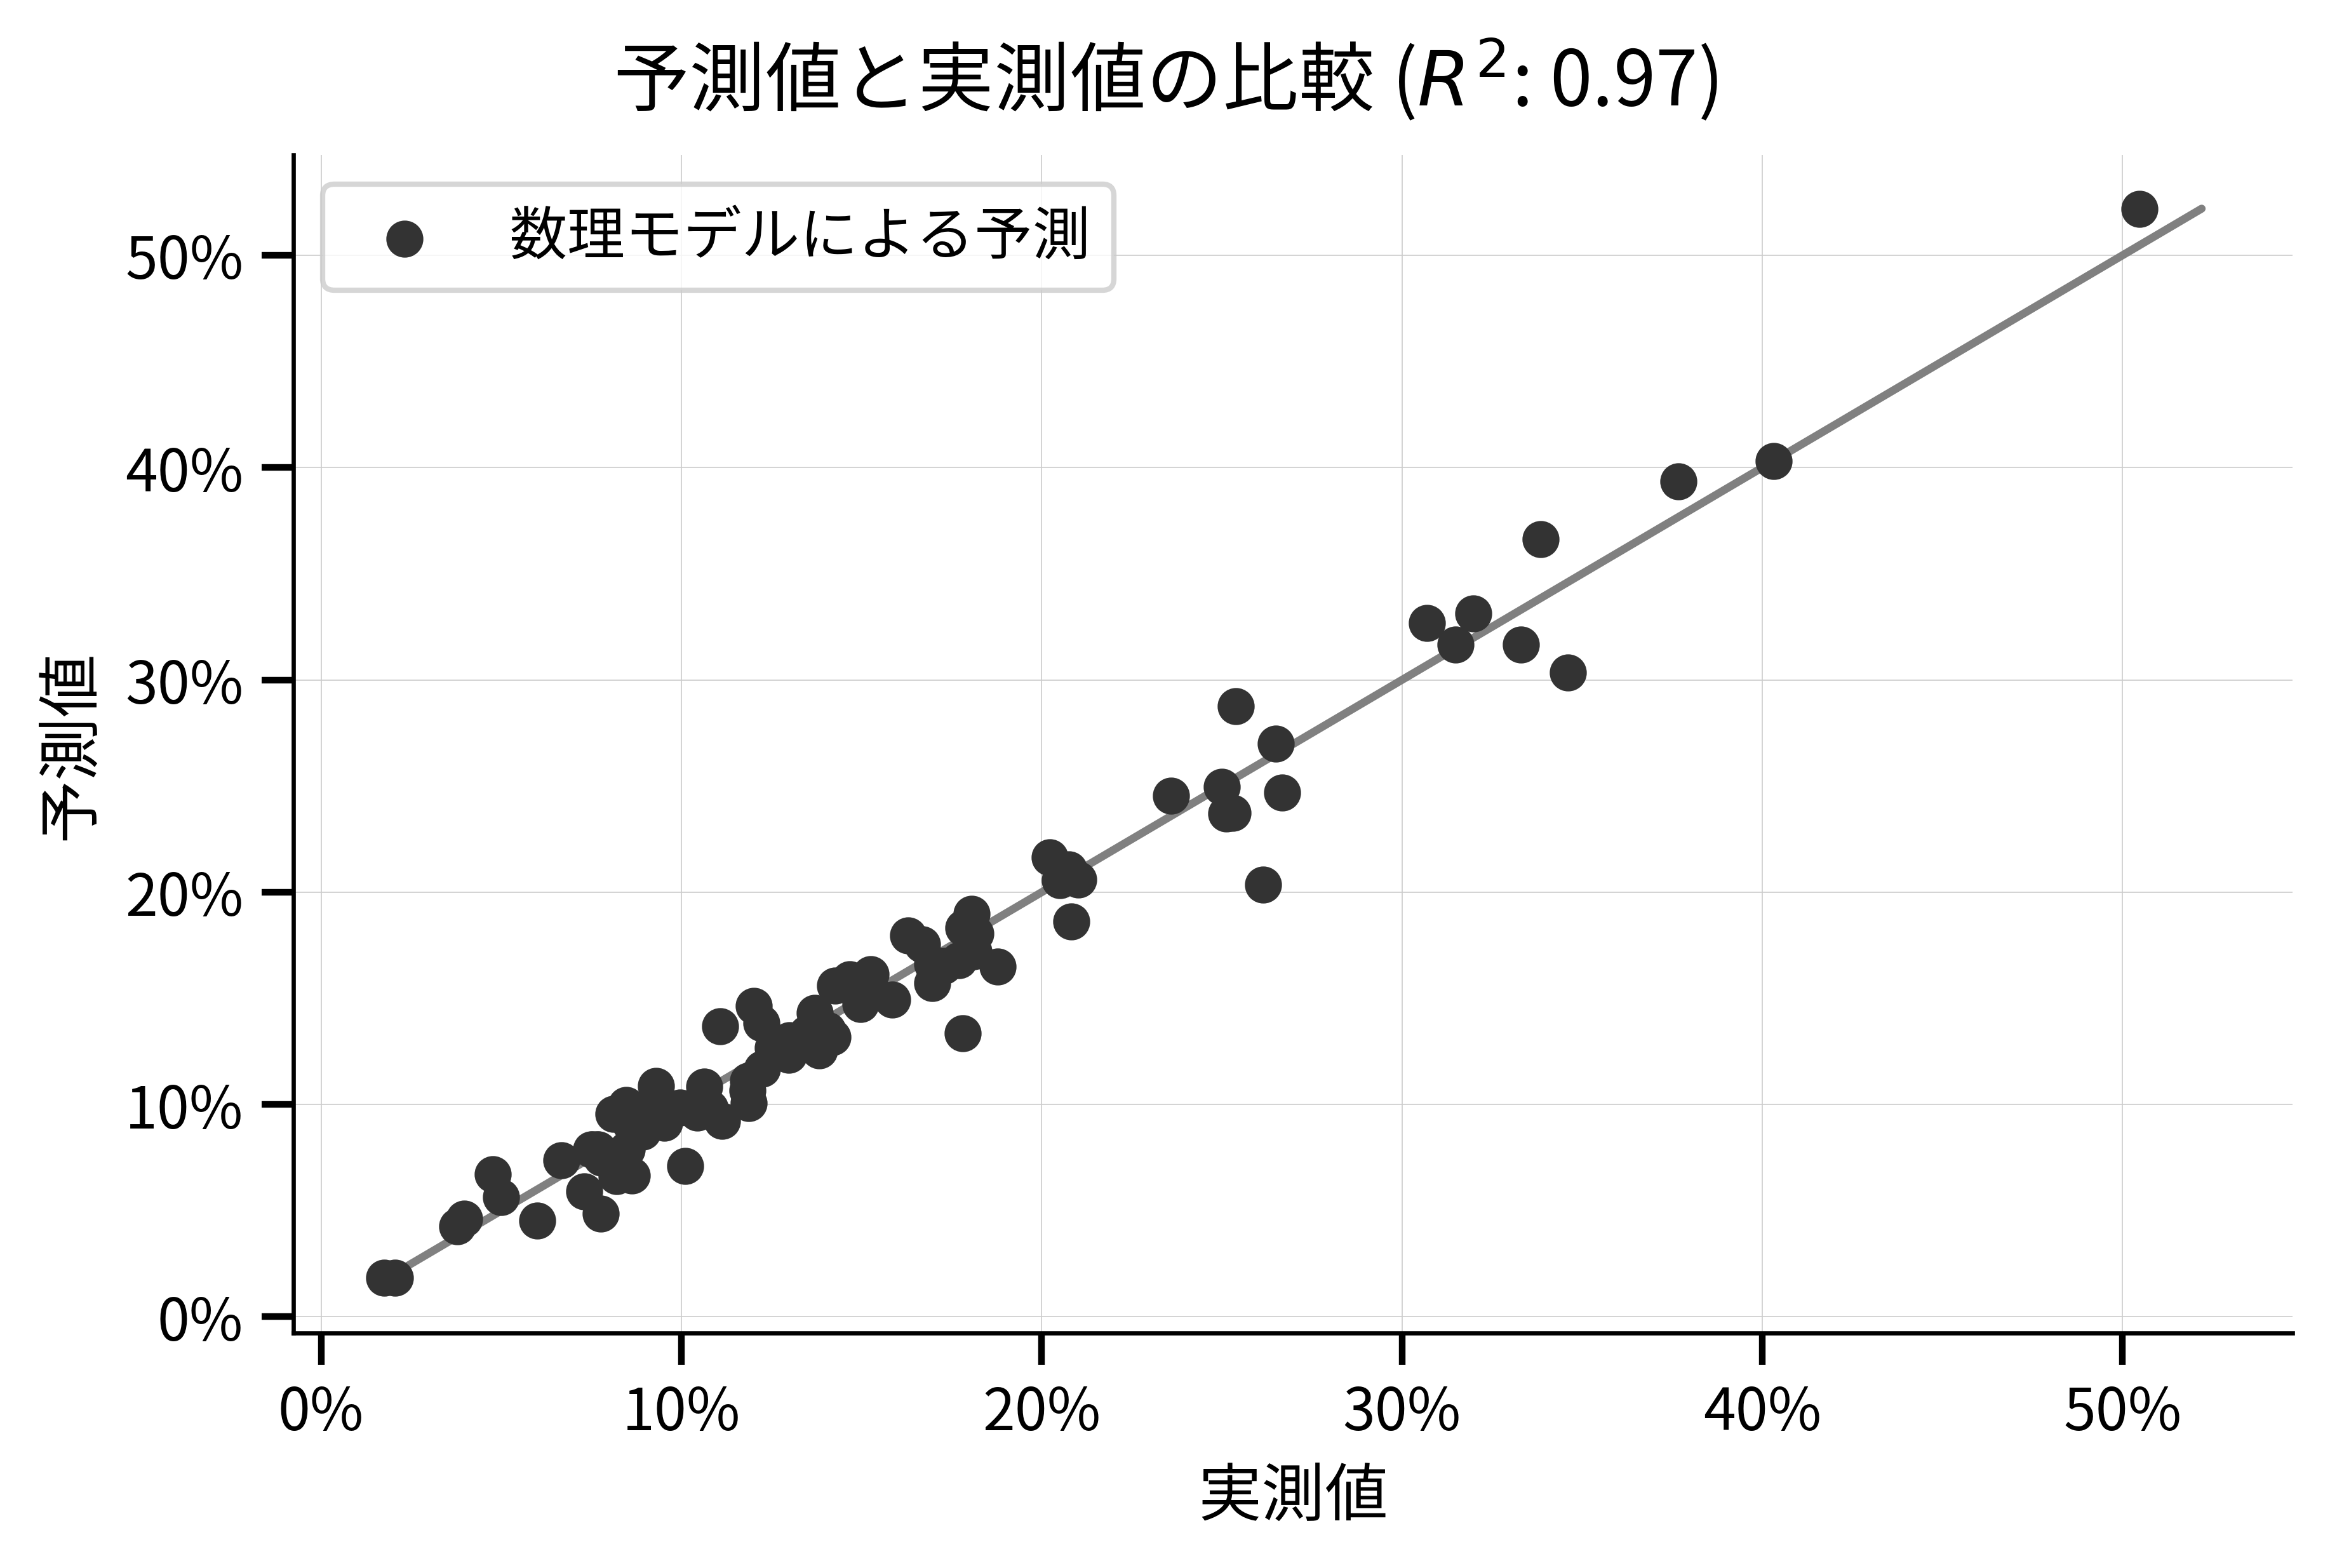

In [17]:
# モデルの学習
pure = ProgramUniqueReachEstimator(PI_train)

# 検証用データに対して予測
y_pred_pure = pure.predict(X_valid)

# 可視化
fig, ax = plot_compare_actual_prediction(
    y_true=y_valid,
    y_pred=y_pred_pure,
    prediction_label="数理モデルによる予測",
    title="予測値と実測値の比較",
)

## ステップ3：数理最適化問題を解いて 最適なアクションを導出する

In [18]:
def greedy_search(
    estimator: ProgramUniqueReachEstimator,
    b: float,
    c: np.ndarray,
) -> tuple[float, list[int]]:
    """予算内で最大のユニークリーチを達成する番組群を貪欲法で探索する"""

    # 番組候補の数
    m = c.shape[0]
    # 選択した番組群。最初は何も選択していいない。これを更新していく
    D = np.zeros((1, m))
    # 選択した番組のリスト
    j_list_opt: list[int] = []

    # 予算内を超えない限り番組を追加していく
    while True:
        # 番組追加前の合算ユニークリーチ
        r_before = estimator.predict(D)[0]

        # 番組を追加した場合の合算のユニークリーチの増加幅を計算
        delta = np.zeros(m)  # 差分
        for j in range(m):
            # すでに選択されている番組はスキップ
            if D[0, j] == 1:
                continue

            # 番組j+1を追加
            # インデックスが0始まりなので、正確にはjではなくj+1が追加される
            D_ = D.copy()
            D_[0, j] = 1

            # 予算内に収まらない場合はスキップ
            if c @ D_.flatten() > b:
                continue

            # 番組j+1を追加した場合の合算のユニークリーチの増加幅を計算
            r_after = estimator.predict(D=D_)[0]

            delta[j] = (r_after - r_before) / c[j]

        # コストパフォーマンスが最も高い番組を追加
        j_to_add = int(np.argmax(delta))
        D[0, j_to_add] = 1

        # 予算内に収まらない場合は番組の追加を取りやめて終了
        if c @ D.flatten() > b:
            D[0, j_to_add] = 0
            break

        # インデックスは0始まりなので、1を足して追加
        j_list_opt.append(j_to_add + 1)

    # 最終的な合算のユニークリーチと、それを達成する番組群を返す
    return estimator.predict(D)[0], j_list_opt

In [19]:
# 番組候補の数
m = X_valid.shape[1]

# 最適な番組群を選択
r_opt, j_list_opt = greedy_search(
    estimator=pure,
    b=5000,
    c=np.ones(m) * 500,
)

# 結果の確認
r_opt, j_list_opt

(0.49144801673265814, [5, 74, 32, 112, 50, 26, 76, 61, 33, 44])

In [20]:
# 企業ごとの出稿番組の最大数
# 検証は評価用データで行う
max_sum_d = df_company_reach_valid.select(pl.col.sum_d.max()).item()

# 貪欲法で最大の番組数に対する最適な番組群を探索
_, j_list_opt = greedy_search(
    estimator=pure,
    b=max_sum_d,
    c=np.ones(m),
)

# 番組数ごとに最適な合算のユニークリーチを計算
# j_list_optはコストパフォーマンスが高い順に番組を追加しているので、
# j_list_optの先頭から番組を追加していくと、番組数ごとに貪欲法で最適解を探索した場合を同じ結果を得ることができる
r_opts = np.zeros(max_sum_d)
for i, sum_d in enumerate(range(1, max_sum_d + 1)):
    # 番組数ごとに最適な番組群を選択
    # インデックスに変換しないといけないので1を引いている
    D = np.zeros((1, m))
    D[0, np.array(j_list_opt[:sum_d]) - 1] = 1

    # 番組数ごとの最適な合算のユニークリーチ
    r_opts[i] = pure.predict(D)[0]

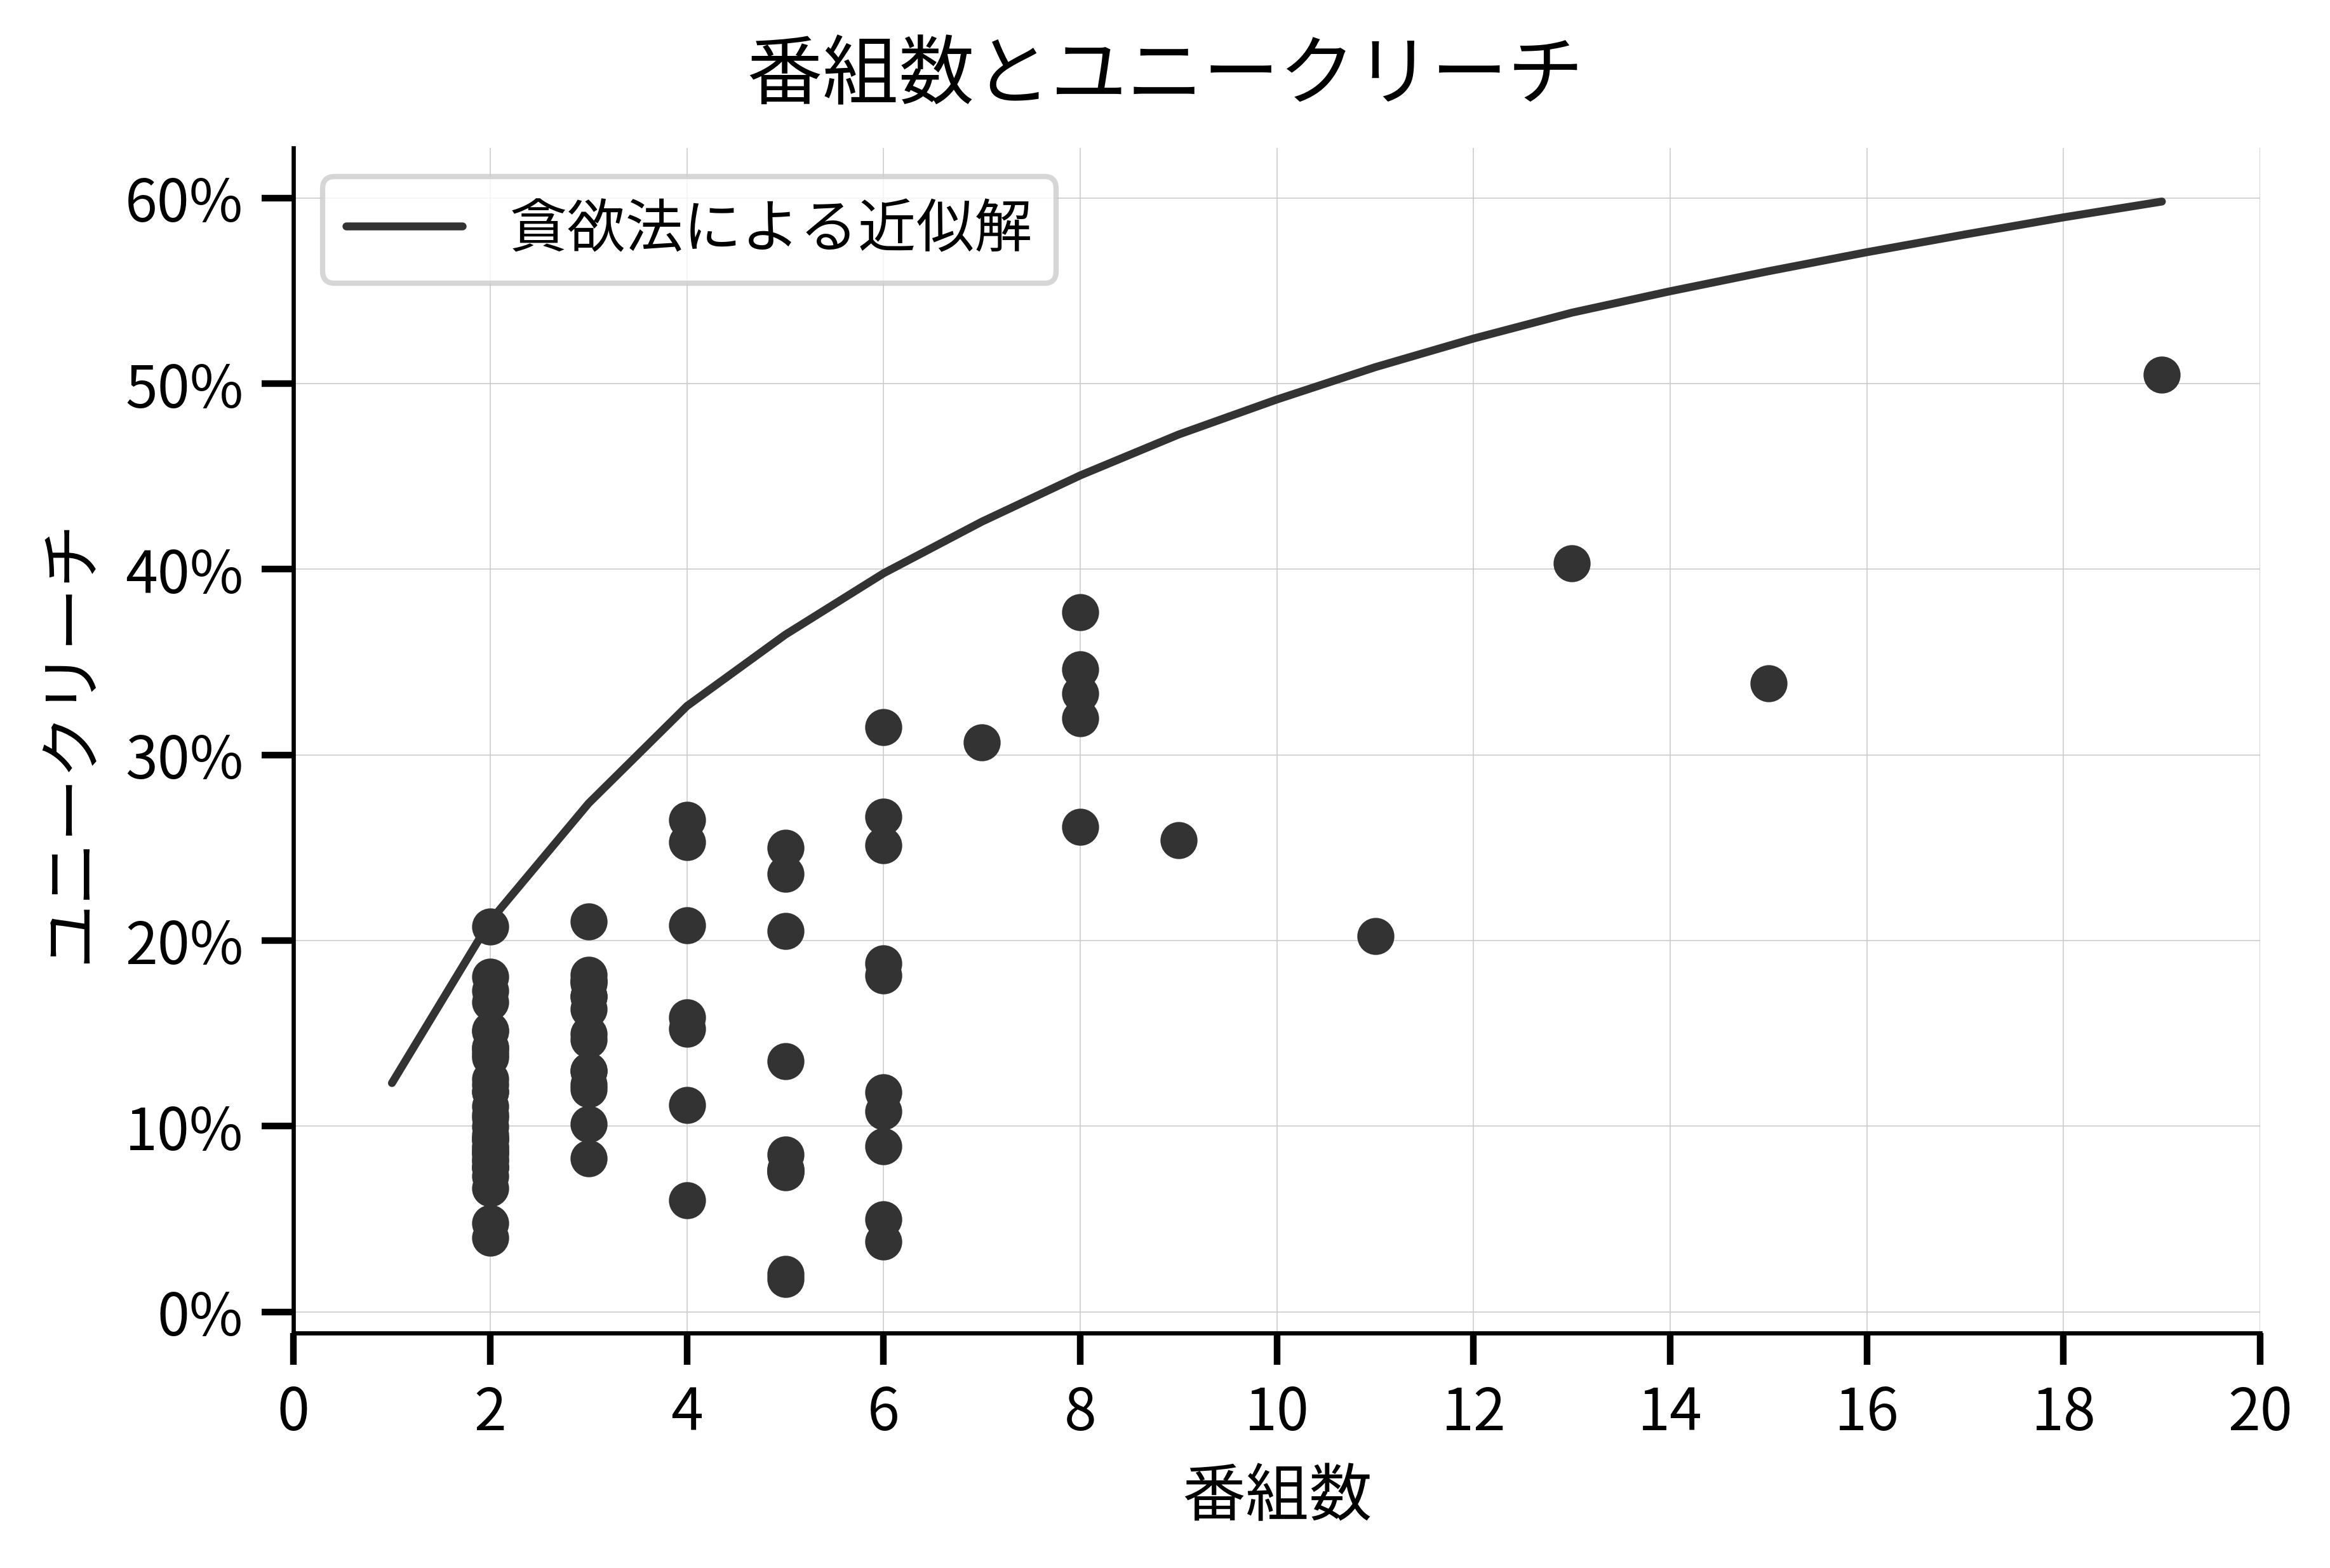

In [21]:
def plot_scatter_with_optimal_reach(df: pl.DataFrame, r_opts: np.ndarray):
    fig, ax = plot_scatter(
        x=df.get_column("sum_d"),
        y=df.get_column("r"),
        xlabel="番組数",
        ylabel="ユニークリーチ",
        title="番組数とユニークリーチ",
    )

    # 貪欲法による近似解をプロット
    ax.plot(
        range(1, r_opts.shape[0] + 1),
        r_opts,
        label="貪欲法による近似解",
    )
    ax.legend()
    ax.set_xticks(np.arange(0, r_opts.shape[0] + 2, 2))


# 評価用データで実測値と貪欲法による近似解を可視化
plot_scatter_with_optimal_reach(df=df_company_reach_valid, r_opts=r_opts)

## まとめ

## 付録：フリークエンシー分布の推定

In [22]:
# パネルの人数
n = df_individual_reach_train.select(pl.col.i.n_unique()).item()

# 9番組にCMを出稿している企業のデータを抽出（キリの良い10番組にCMを出稿している企業がなかったので）
k_to_use = df_company_reach_train.filter(pl.col.sum_d == 9).get_column("k").max()

# 個人ごとの接触データからフリークエンシーの分布を計算
df_frequency = (
    df_individual_reach_train.filter(pl.col("k") == k_to_use)  # 企業0の出稿したCMに限定
    .group_by("i")
    .agg(f=pl.col("r").sum())  # 個人ごとにフリークエンシーを計算
    .group_by("f")
    .agg(prop=pl.col.i.n_unique() / n)  # 割合を計算
    .sort("f")
)


# データの確認
print(f"企業{k_to_use}のフリークエンシー分布")
df_frequency

企業48のフリークエンシー分布


f,prop
i64,f64
0,0.556
1,0.220
2,0.111
3,0.063
4,0.029
5,0.014
6,0.005
7,0.000
8,0.000


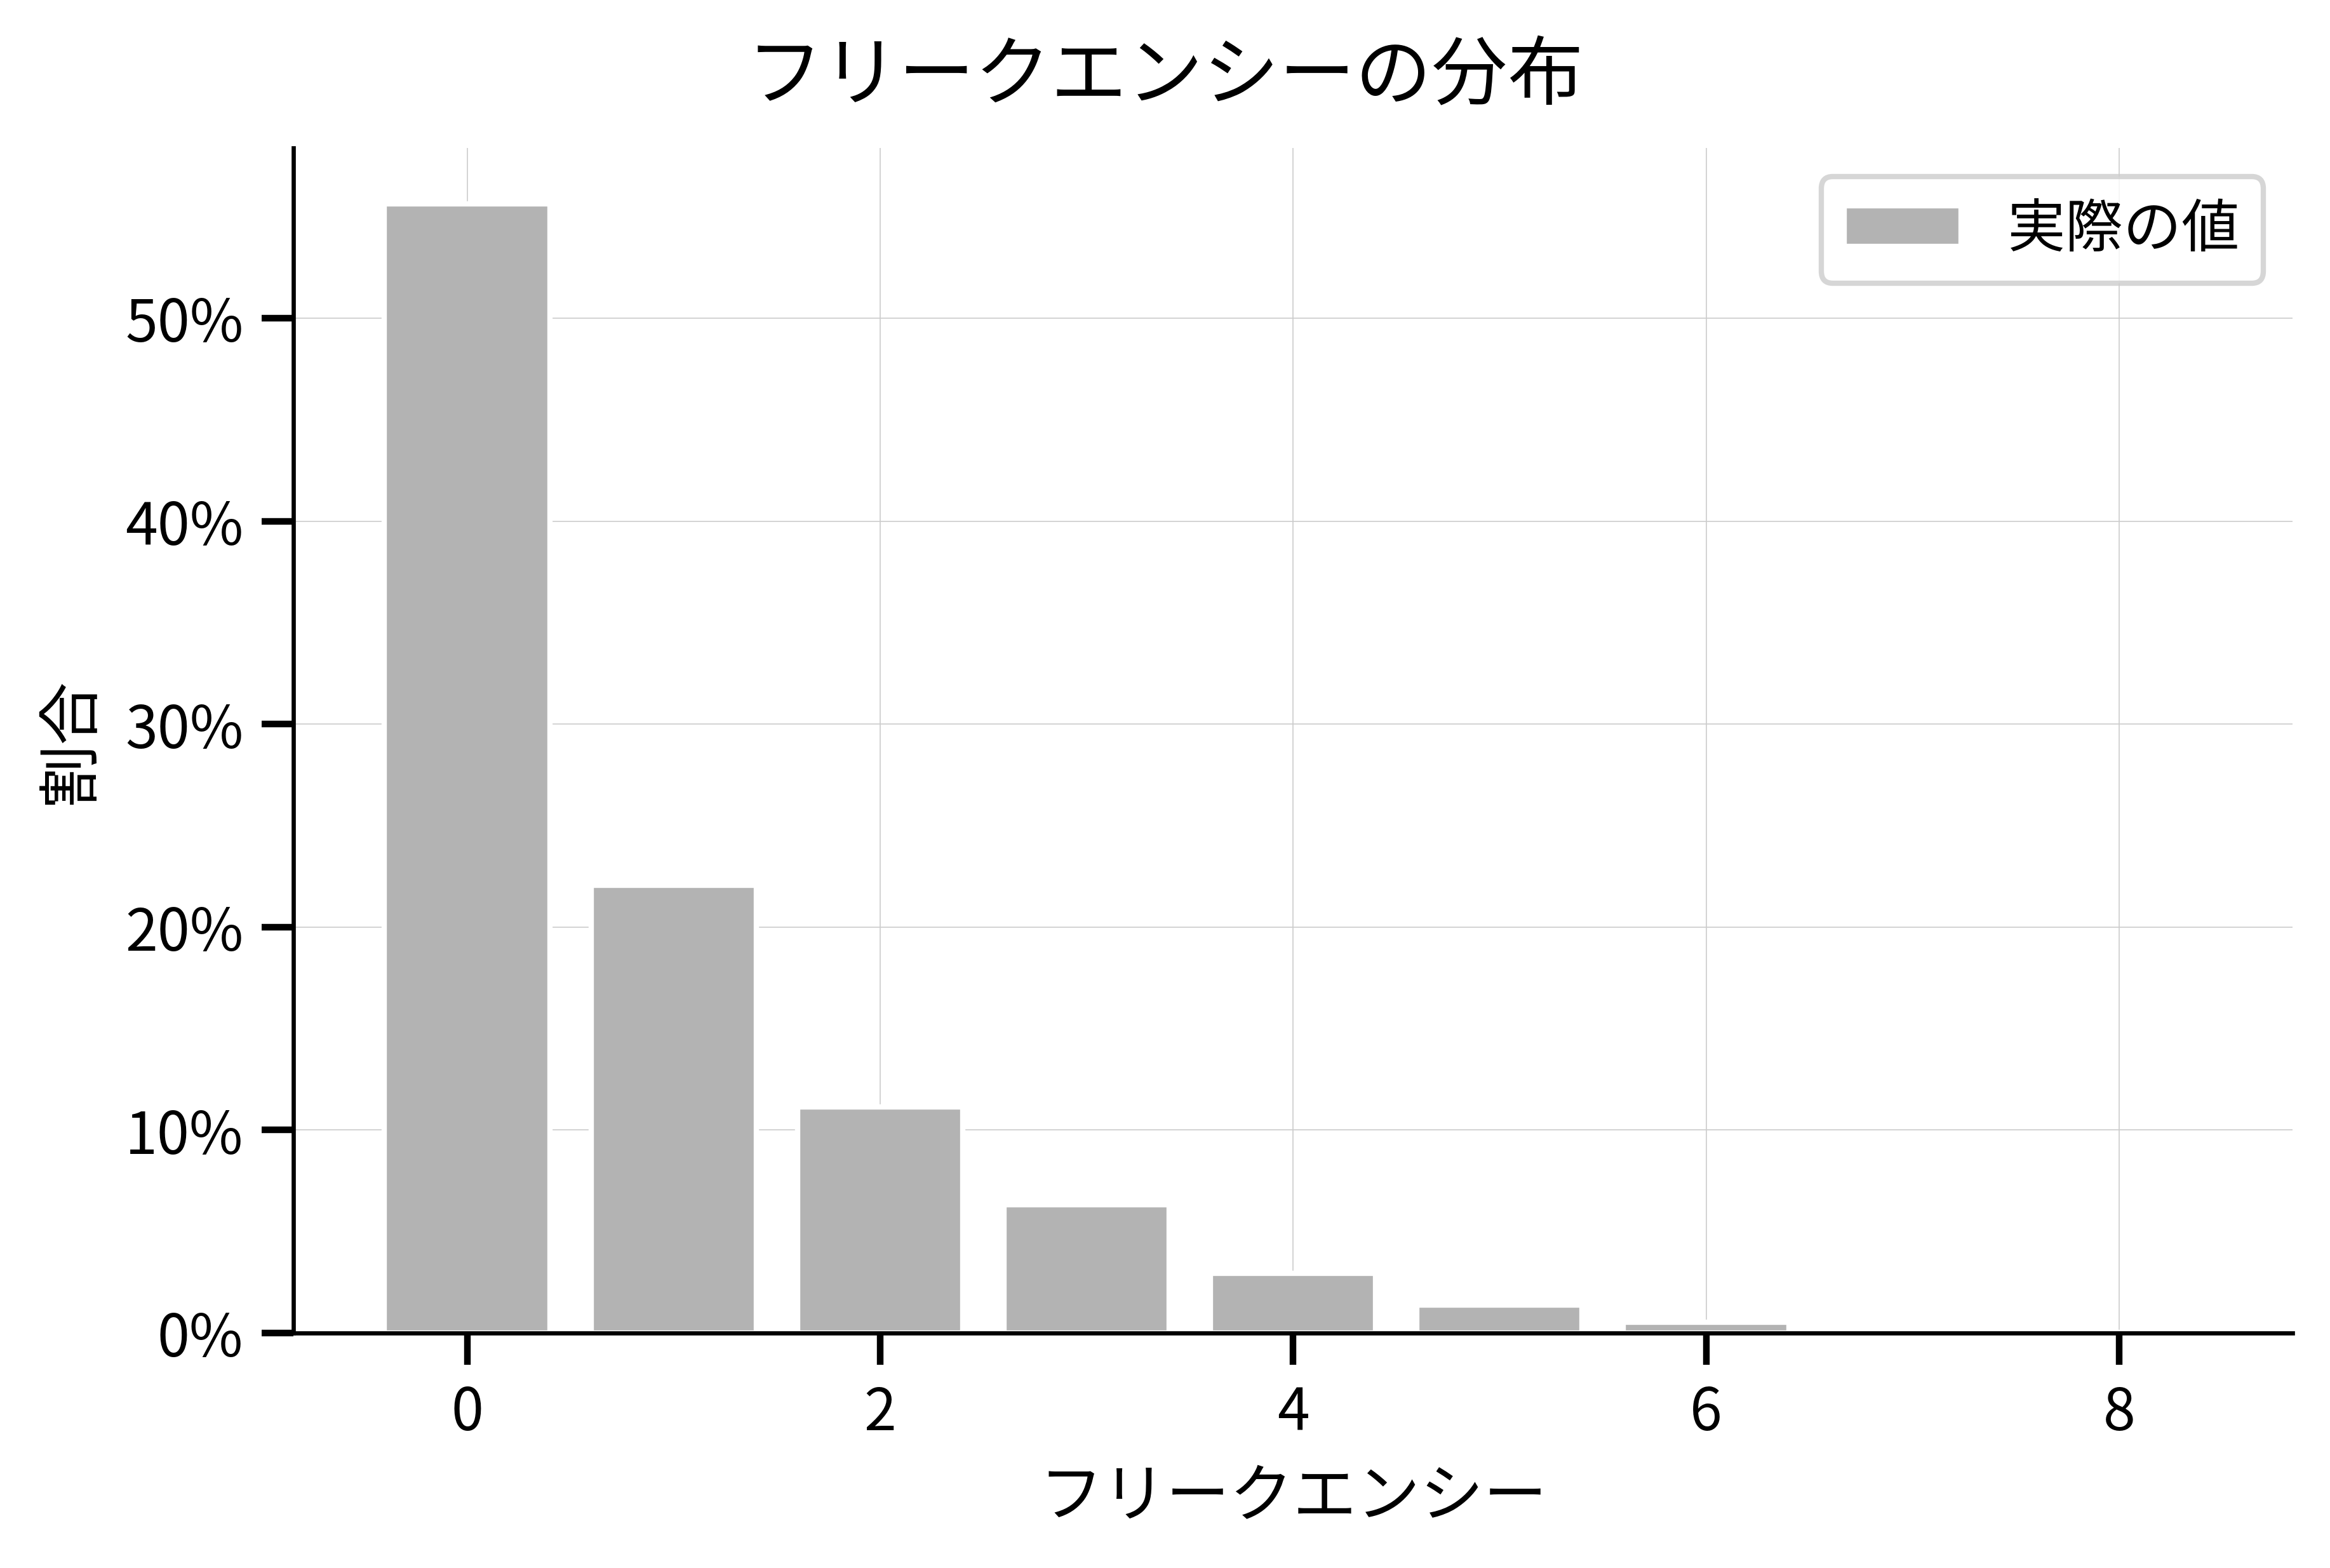

In [23]:
def plot_histogram(
    df_frequency: pl.DataFrame, f_max: int, title: str
) -> tuple[Figure, Axes]:
    """フリークエンシーの分布を可視化"""

    # 横に長くなりすぎるとうまく可視化できないで、必要であればf_max以下のデータのみを使う
    df_to_use = df_frequency.filter(pl.col.f <= f_max)

    fig, ax = plt.subplots()

    ax.bar(
        df_to_use["f"],
        df_to_use["prop"],
        label="実際の値",
        color="0.7",
    )
    ax.legend()
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_xlabel("フリークエンシー")
    ax.set_ylabel("割合")
    fig.suptitle(title)

    return fig, ax


# 選択した番組数
sum_d_to_use = (
    df_company_reach_train.filter(pl.col.k == k_to_use).get_column("sum_d").item()
)

# 可視化
fig, ax = plot_histogram(
    df_frequency=df_frequency,
    f_max=sum_d_to_use,
    title="フリークエンシーの分布",
)

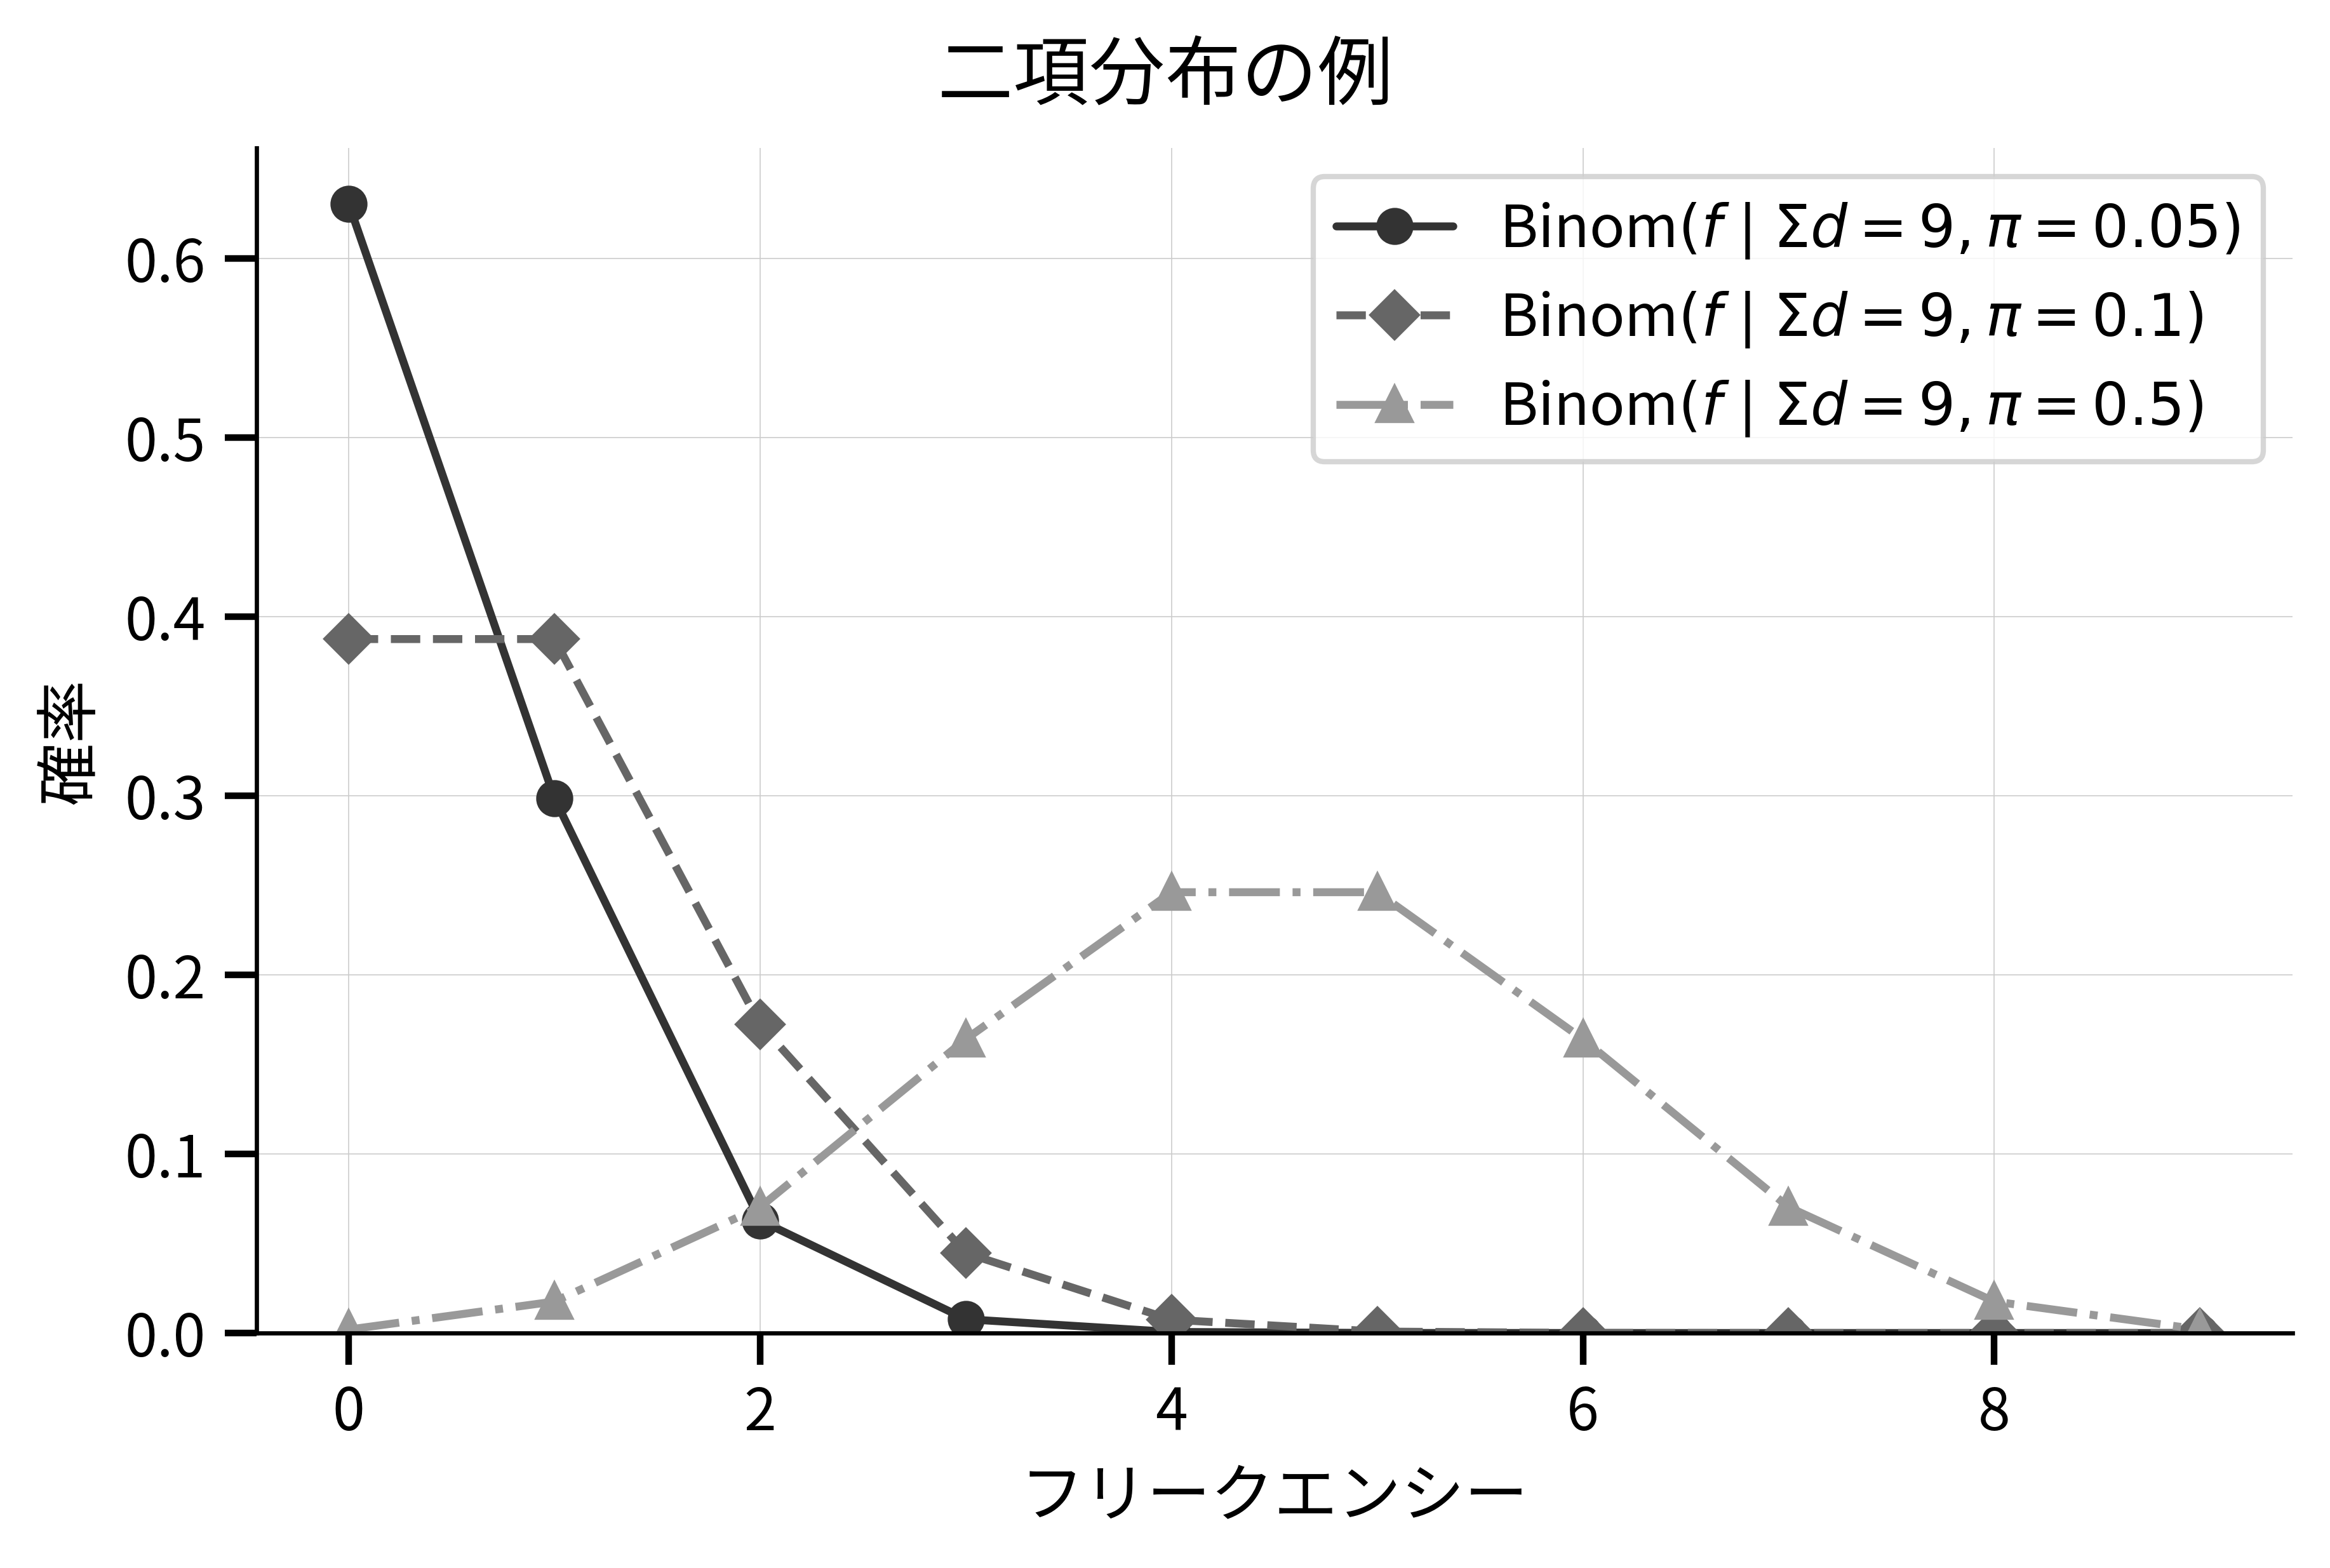

In [24]:
from scipy.stats import binom


def plot_binom(f: np.ndarray, sum_d: int, pi_list: list[float]) -> tuple[Figure, Axes]:
    """二項分布を可視化"""

    fig, ax = plt.subplots()

    markers = ["o", "D", "^", "x"]
    linestyles = ["solid", "dashed", "dashdot", "dotted"]
    for i, pi in enumerate(pi_list):
        y = binom.pmf(k=f, n=sum_d, p=pi)
        ax.plot(
            f,
            y,
            marker=markers[i % len(markers)],
            linestyle=linestyles[i % len(linestyles)],
            label=f"Binom$(f \\mid \\Sigma d = {sum_d}, \\pi = {pi})$",
        )

    ax.legend()
    ax.set_ylim(0, None)
    ax.set_xlabel("フリークエンシー")
    ax.set_ylabel("確率")
    fig.suptitle("二項分布の例")

    return fig, ax


# 二項分布を可視化
fig, ax = plot_binom(
    f=np.arange(10),
    sum_d=sum_d_to_use,
    pi_list=[0.05, 0.1, 0.5],
)

In [25]:
class BinomialFrequencyEstimator:
    """二項分布を仮定したフリークエンシーの分布を推定するモデル"""

    def __init__(self, PI: np.ndarray) -> None:
        """個人ごとのCM接触確率を保持

        Args:
            PI (np.ndarray): 個人iが番組jのCMに接触する確率
        """

        self.PI_ = PI

    def fit_predict(self, D: np.ndarray) -> np.ndarray:
        """フリークエンシーの分布を予測

        Args:
            D (np.ndarray): 選択した番組群。1行m列を想定

        Returns:
            np.ndarray: フリークエンシーの分布の予測値
        """
        # 選択した番組数
        sum_d = D.sum()

        # CM接触確率の全体平均。学習結果は`pi_`に格納
        self.pi_ = np.mean((self.PI_ * D).sum(1) / sum_d)

        # 二項分布を用いてフリークエンシーの分布を予測
        return binom.pmf(k=np.arange(sum_d + 1), n=sum_d, p=self.pi_)

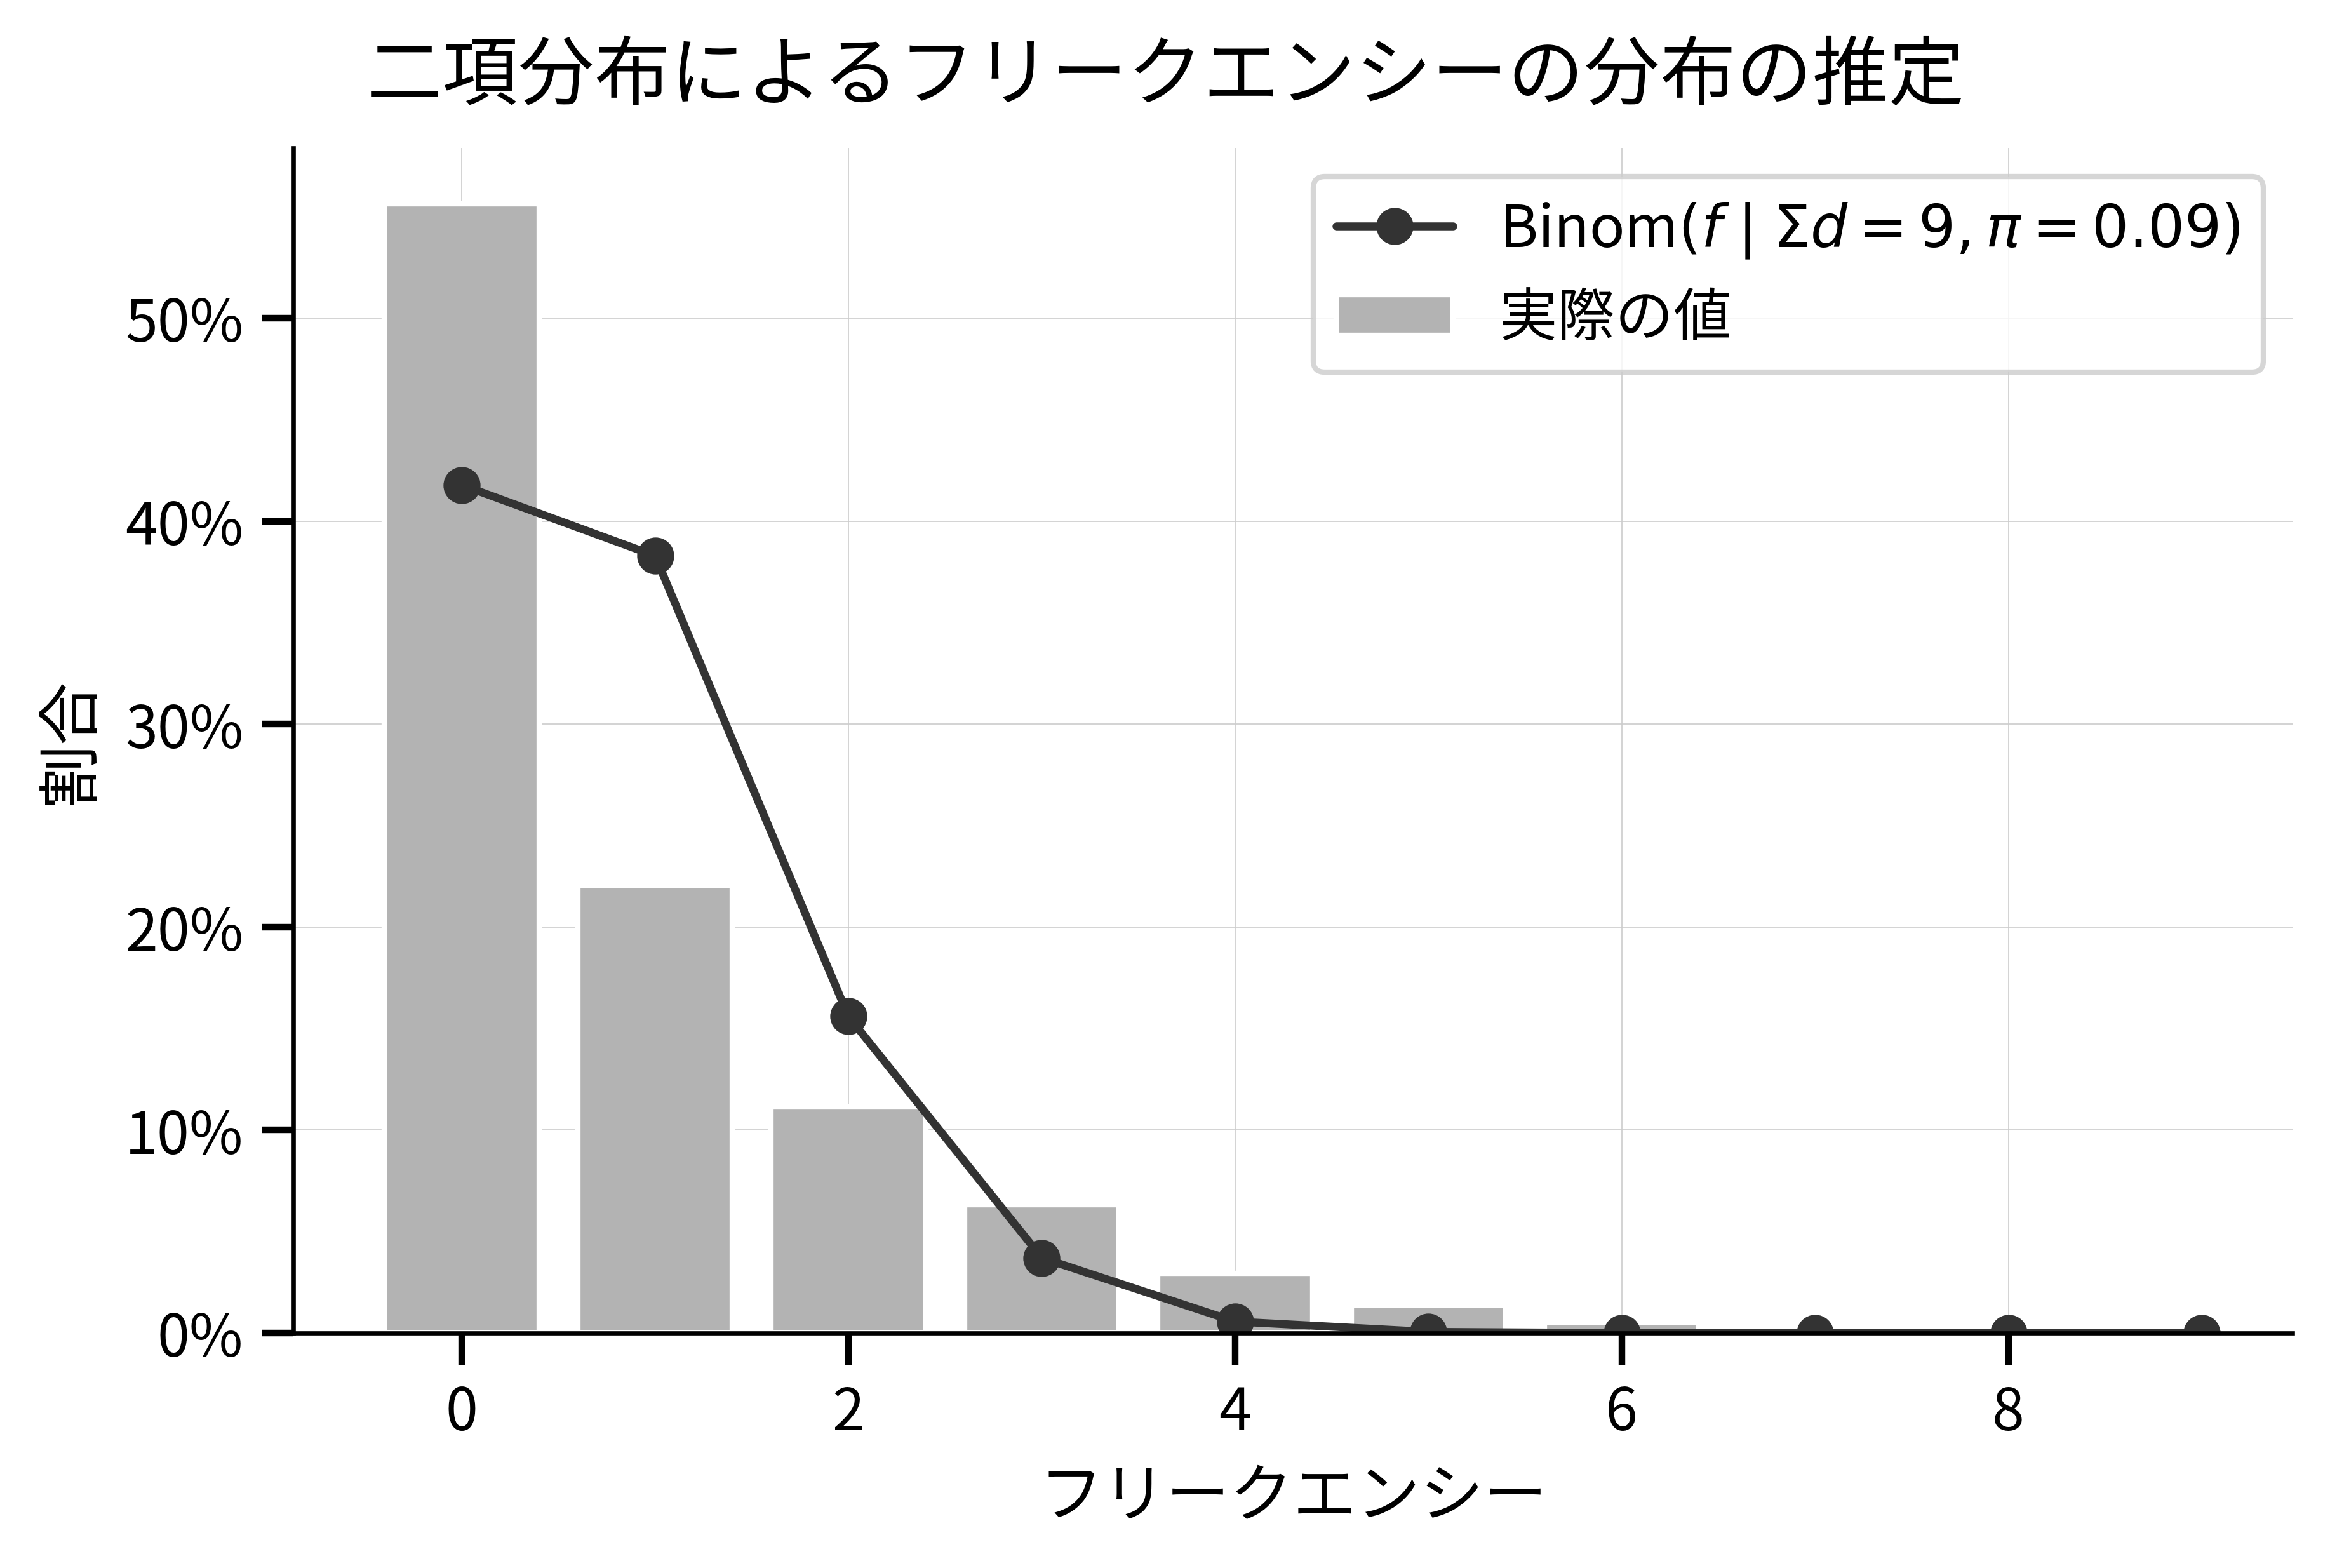

In [26]:
def plot_histogram_with_distribution(
    df_frequency: pl.DataFrame,
    prop_pred: np.ndarray,
    prop_label: str,
    f_max: int,
    title: str,
) -> tuple[Figure, Axes]:
    """フリークエンシーの分布と、近似する分布を重ね合わせて可視化"""

    fig, ax = plot_histogram(df_frequency=df_frequency, f_max=f_max, title=title)
    ax.plot(
        range(f_max + 1),
        prop_pred,
        marker="o",
        label=prop_label,
    )  # 近似する分布を追加
    ax.legend()

    return fig, ax


# 企業48に選択した番組群
D_to_use = (
    df_company_reach_train.filter(pl.col.k == k_to_use)
    .select(pl.selectors.starts_with("d_"))
    .to_numpy()
)

# フリークエンシーの分布の推定
bfe = BinomialFrequencyEstimator(PI=PI_train)
prop_binomial = bfe.fit_predict(D_to_use)

# フリークエンシーの分布と二項分布を重ね合あわせて可視化
fig, ax = plot_histogram_with_distribution(
    df_frequency=df_frequency,
    prop_pred=prop_binomial,
    prop_label=f"Binom$(f \\mid \\Sigma d = {sum_d_to_use}, \\pi = {bfe.pi_: .2f})$",
    f_max=sum_d_to_use,
    title="二項分布によるフリークエンシーの分布の推定",
)

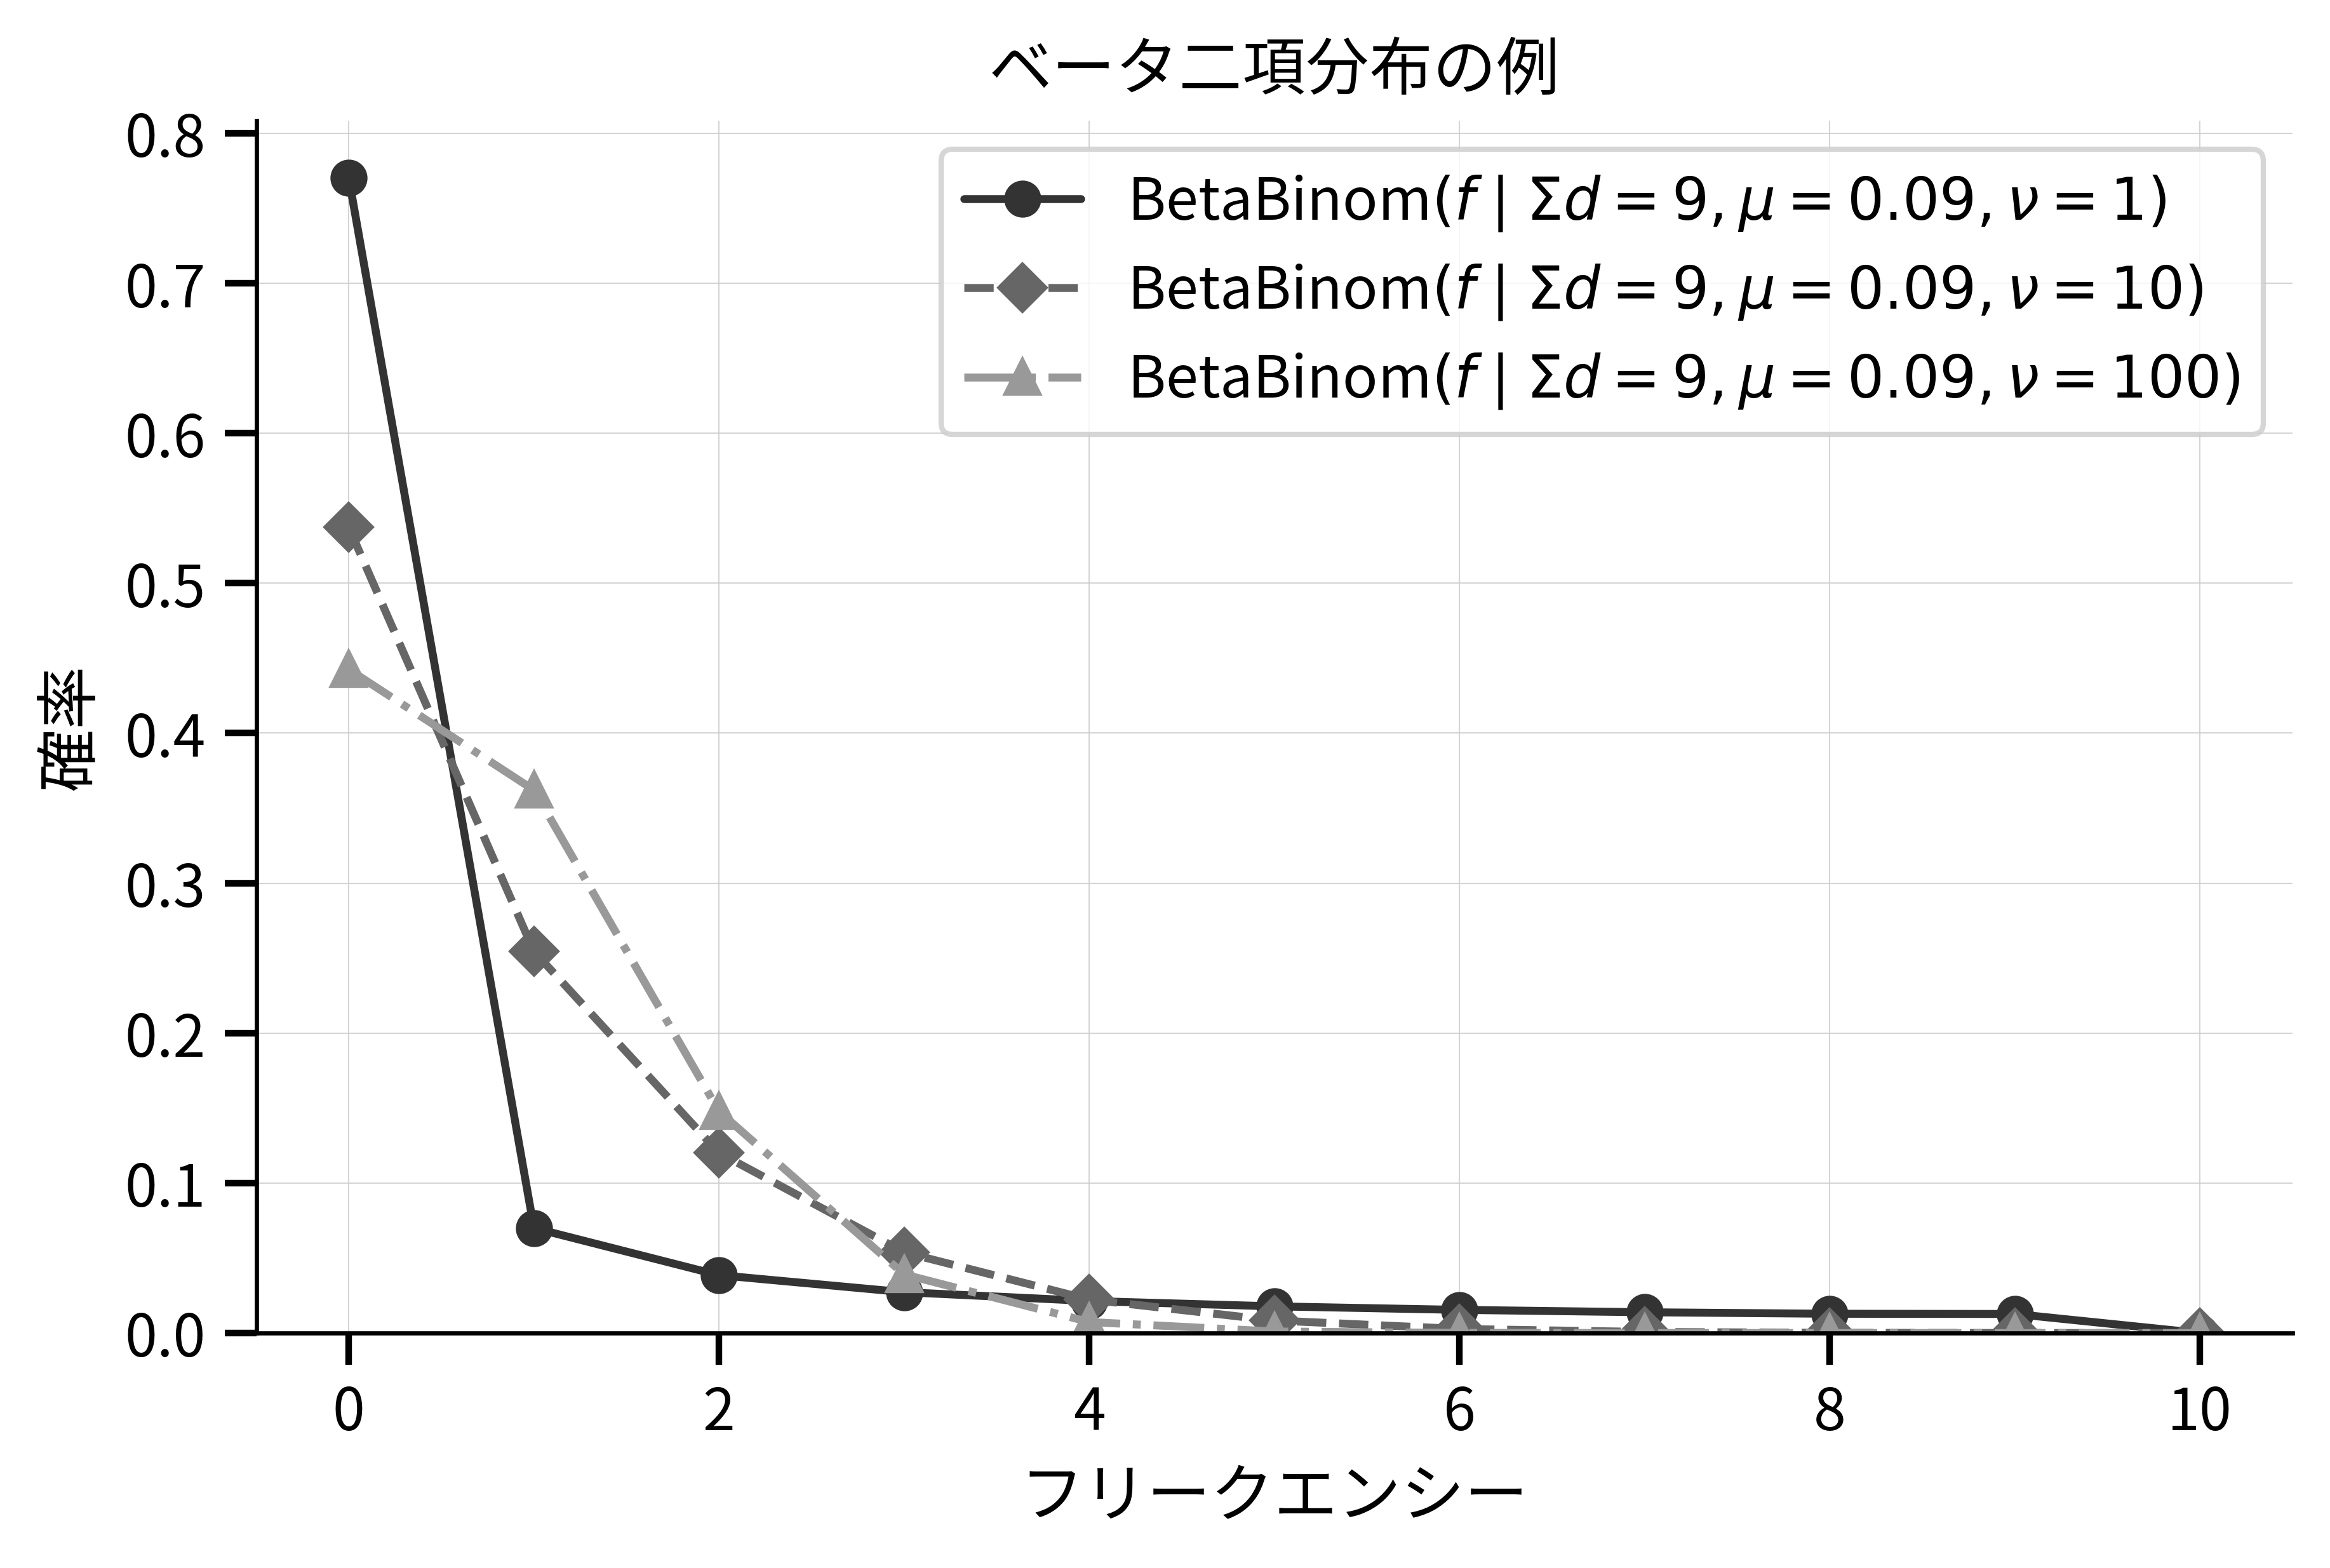

In [27]:
from scipy.stats import betabinom


def plot_betabinom(
    f: np.ndarray,
    sum_d: int,
    mu_list: list[float],
    nu_list: list[float],
) -> tuple[Figure, Axes]:
    """ベータ二項分布を可視化"""

    fig, ax = plt.subplots()
    markers = ["o", "D", "^", "x"]
    linestyles = ["solid", "dashed", "dashdot", "dotted"]
    for i, (mu, nu) in enumerate(zip(mu_list, nu_list)):
        y = betabinom.pmf(k=f, n=sum_d, a=mu * nu, b=(1 - mu) * nu)
        ax.plot(
            f,
            y,
            marker=markers[i % len(markers)],
            linestyle=linestyles[i % len(linestyles)],
            label=f"BetaBinom$(f \\mid \\Sigma d = {sum_d}, \\mu = {mu}, \\nu = {nu})$",
        )

    ax.legend()
    ax.set_ylim(0, None)
    ax.set_xlabel("フリークエンシー")
    ax.set_ylabel("確率")
    ax.set_title("ベータ二項分布の例")

    return fig, ax


# ベータ二項分布の例を可視化
fig, ax = plot_betabinom(
    f=np.arange(11),
    sum_d=sum_d_to_use,
    mu_list=[bfe.pi_.round(2)] * 3,
    nu_list=[1, 10, 100],
)

In [28]:
from scipy.optimize import minimize_scalar


class BetaBinomialFrequencyEstimator(ProgramUniqueReachEstimator):
    """ベータ二項分布でフリークエンシーの分布を推定するモデル"""

    def fit_predict(self, D: np.ndarray) -> np.ndarray:
        """フリークエンシーの分布を予測

        Args:
            D (np.ndarray): 選択した番組群。1行m列を想定

        Returns:
            np.ndarray: フリークエンシーの分布の予測値
        """

        sum_d = D.sum()
        r_ = self.predict(D)[0]
        self.mu_ = np.mean((self.PI_ * D).sum(1) / sum_d)

        # ベータ二項分布のパラメータnuを推定
        self.nu_ = minimize_scalar(
            fun=lambda nu: (
                (1 - r_)
                - betabinom.pmf(
                    k=0,
                    n=sum_d,
                    a=self.mu_ * nu,
                    b=(1 - self.mu_) * nu,
                )
            )
            ** 2,
            bounds=(0, 50),
            method="bounded",
        ).x

        return betabinom.pmf(
            k=np.arange(sum_d + 1),
            n=sum_d,
            a=self.mu_ * self.nu_,
            b=(1 - self.mu_) * self.nu_,
        )

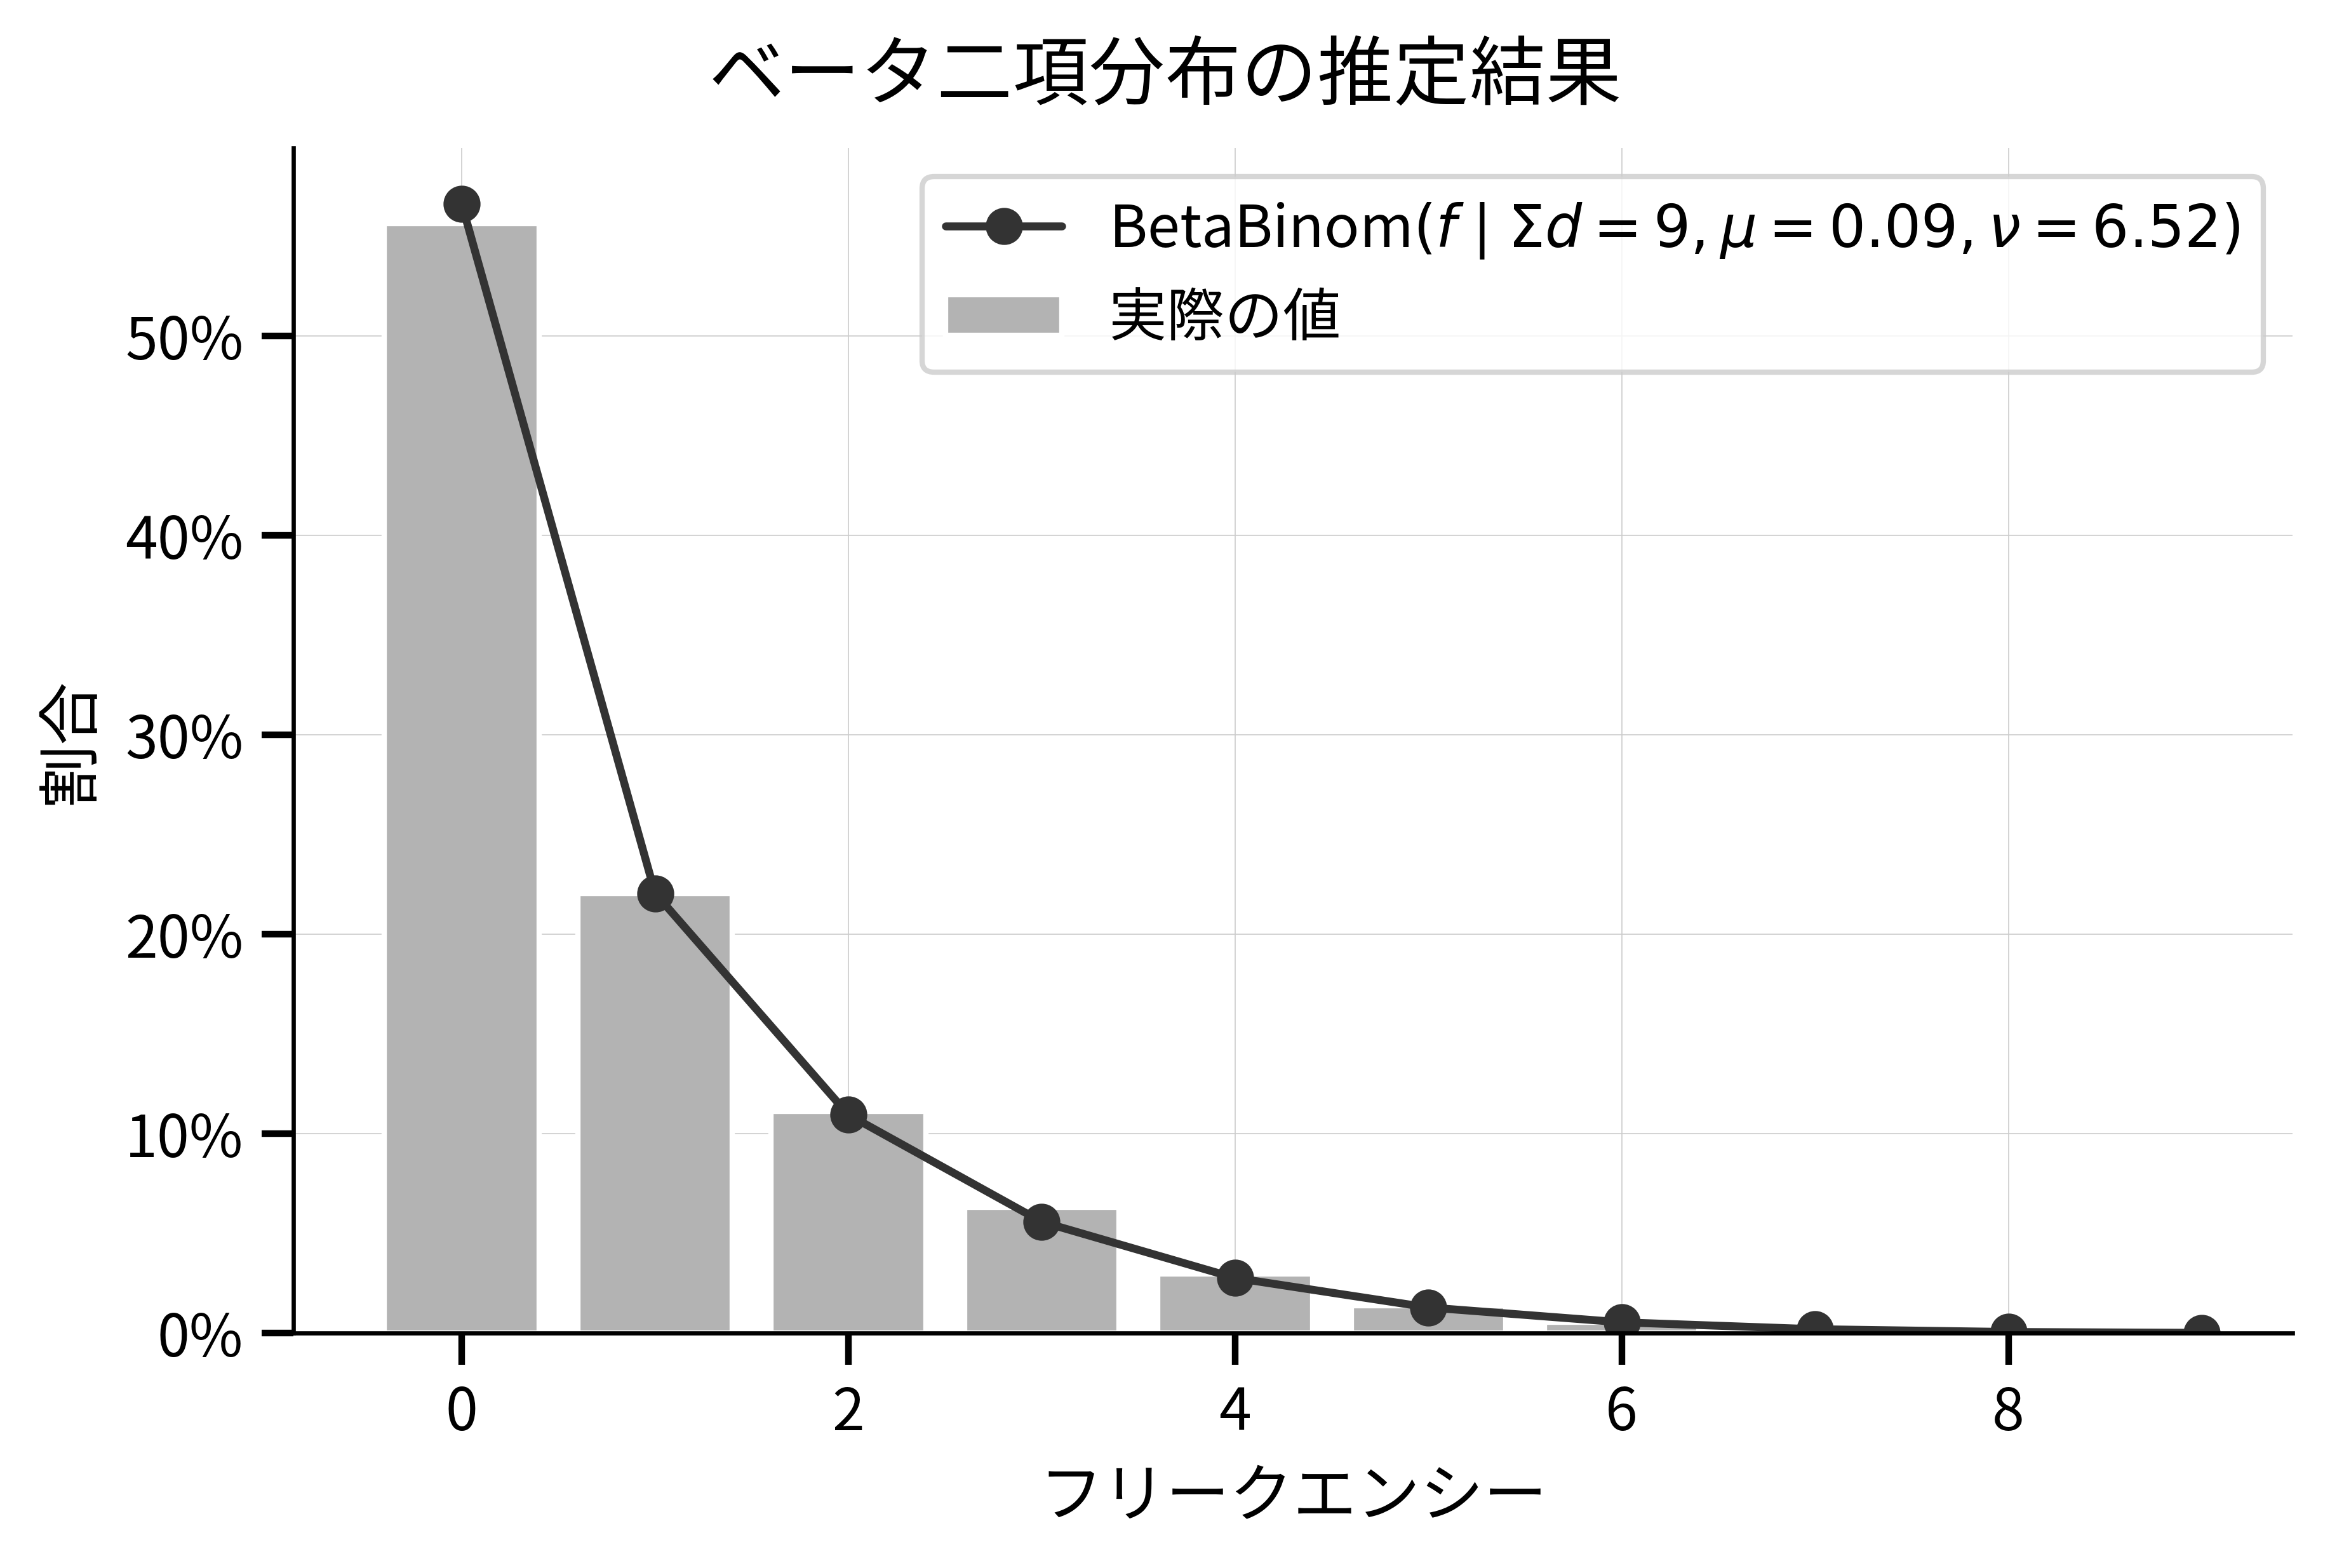

In [29]:
# ベータ二項分布によるフリークエンシー分布の推定
bbfe = BetaBinomialFrequencyEstimator(PI=PI_train)
prop_betabinomial = bbfe.fit_predict(D=D_to_use)

# CM接触回数分布とベータ二項分布による推定結果を重ね合わせて可視化
fig, ax = plot_histogram_with_distribution(
    df_frequency=df_frequency,
    prop_pred=prop_betabinomial,
    prop_label=f"BetaBinom$(f \\mid \\Sigma d = {sum_d_to_use}, \\mu = {bbfe.mu_: .2f}, \\nu = {bbfe.nu_: .2f})$",
    f_max=sum_d_to_use,
    title="ベータ二項分布の推定結果",
)

## 付録：合算のユニークリーチを各番組の貢献度に分解する

In [ ]:
class ContributionDecomposer(ProgramUniqueReachEstimator):
    """ユニークリーチの貢献度分解手法を実装したモデル"""

    def decompose_contribution(
        self,
        D: np.ndarray,
    ) -> pl.DataFrame:
        """貢献度を分解する

        Args:
            D (np.ndarray): 選択した番組群。1行m列を想定

        Returns:
            pl.DataFrame: 貢献度の分解結果
        """

        # 選択した番組群のインデックス
        j_indices = np.where(D)[1]
        # 選択した番組群の接触確率だけにデータを限定
        PI = self.PI_[:, j_indices]

        # 番組単体のユニークリーチ
        r_single = PI.mean(0)
        # 選択した番組群の合算のユニークリーチ
        r_full = self.predict(D)[0]  # floatにするため[0]で取り出す

        ### 貢献度1: 番組単体のユニークリーチによる貢献度 ###
        phi_single = r_single

        ### 貢献度2: 番組固有のユニークリーチによる貢献度 ###
        # 番組を一つ外した場合に合算のユニークリーチがどれだけ減少するかで測定
        phi_loo = np.zeros(len(j_indices))
        for i, j_index in enumerate(j_indices):
            D_ = D.copy()
            D_[0, j_index] = 0
            phi_loo[i] = r_full - self.predict(D_)[0]

        ### 貢献度3: Shapley値による貢献度（1階近似） ###
        # 1 - Π_j (1 - π_ij)を計算
        # PIを割る際にshapeが(n, 1)になるようにkeepdims=Trueを指定
        r = 1 - (1 - PI).prod(1, keepdims=True)

        # π_ij / Σ_j π_ij を計算
        sum_pi = PI.sum(1, keepdims=True)
        pi_devided_sum_pi = np.nan_to_num(
            PI / np.where(sum_pi == 0, np.nan, sum_pi),
            nan=0,
        )  # 分母が0の場合は0に置換

        # 2つのパートをかけ合わせて平均をとることで貢献度を計算
        phi_shapley = (pi_devided_sum_pi * r).mean(0)

        # 貢献度をDataFrameにまとめて出力
        return pl.DataFrame(
            {
                "j": j_indices + 1,  # インデックスは0始まりなので1を足す
                "single": phi_single,
                "loo": phi_loo,
                "shapley": phi_shapley,
            }
        )

In [31]:
# 5番組にCMを出稿している中で最もユニークリーチを多く獲得している企業を選択
k_contribution = (
    df_company_reach_train.filter(pl.col.sum_d == 5)
    .filter(pl.col.r == pl.col.r.max())
    .select("k")
    .item()
)

# 選択した企業が出稿している番組群
D_contribution = (
    df_company_reach_train.filter(pl.col.k == k_contribution)
    .select(pl.selectors.starts_with("d_"))
    .to_numpy()
)

# 選択した企業の情報
df_company_reach_train.filter(pl.col.k == k_contribution).select(
    "k", "r", "sum_d", "j_list"
)

k,r,sum_d,j_list
u32,f64,u32,list[u32]
65,0.315,5,"[26, 33, … 108]"


In [ ]:
# 貢献度の計算
cd = ContributionDecomposer(PI_train)
df_contribution = cd.decompose_contribution(D=D_contribution)

# 結果を確認
df_contribution.sort("single", descending=True)

j,single,loo,shapley
i64,f64,f64,f64
33,0.099,0.056,0.075
61,0.097,0.046,0.068
26,0.083,0.038,0.058
108,0.079,0.033,0.055
51,0.077,0.043,0.057


In [33]:
# 合算のユニークリーチの推定値
r_pred_contribution = cd.predict(D_contribution)[0]

# 貢献度の合計を計算
sum_contribution = df_contribution.get_column("shapley").sum()

print(f"合算のユニークリーチの推定値: {r_pred_contribution:.3f}")
print(f"貢献度の合計: {sum_contribution:.3f}")


合算のユニークリーチの推定値: 0.313
貢献度の合計: 0.313
